In [4]:
!pip install ipywidgets

Looking in indexes: https://artifactory.michelin.com/api/pypi/pypi/simple


In [140]:
import ipywidgets
import math
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

---

# ⭐ TUNING de CATBOOST Regressor TotalGHGEmissions

---
---

In [141]:
df = pd.read_csv("DF_Last_Tuning.csv")
df = df.drop(columns=["Unnamed: 0"])

df = df.drop(columns=["ENERGYSTARScore", "SiteEnergyUseWN(kBtu)"])

In [142]:
recup_ENERGYSTARScore = pd.read_csv("DF_Last_Tuning.csv")
recup_ENERGYSTARScore = recup_ENERGYSTARScore["ENERGYSTARScore"]

In [143]:
df.shape

(3140, 147)

In [144]:
# Contrôle rapide dtypes :
df[["CouncilDistrictCode","outlier"]] = df[["CouncilDistrictCode","outlier"]].astype(object)

#Récupération des cat_features :
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

---

### 📍 Encodage :

---

In [145]:
from category_encoders import CatBoostEncoder

In [146]:
encoder = CatBoostEncoder()
df[cat_features] = encoder.fit_transform(df[cat_features],y)

X = df.drop(columns=["TotalGHGEmissions"])
y = df['TotalGHGEmissions']

C:\BUSAPPS\Anaconda\lib\site-packages\category_encoders\cat_boost.py:173: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

C:\BUSAPPS\Anaconda\lib\site-packages\category_encoders\cat_boost.py:173: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)



---

### 📍 Scaling :

---

In [147]:
from sklearn.preprocessing import MinMaxScaler

In [148]:
feature_names = X.columns.tolist()

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#### Réduction d'échelle pour faciliter le travail de l'algorithme, repassage de y à l'échelle ensuite

In [149]:
y = y/100

---

### 📍 Split :

---

In [124]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

---

## 📍 Préparation de train Pool et test Pool pour CatBoost :

---

In [125]:
# importing Pool
from catboost import Pool

#feature_names = X.columns.to_list()
#feature_names = ['F{}'.format(i) for i in range(X.shape[1])]

#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_features
train_pool = Pool(data=train_X,
                  label=train_y,
                  #cat_features=cat_features,
                  feature_names=feature_names,
                 )
#Creating pool object for test dataset
test_pool = Pool(data=test_X,
                  label=test_y,
                  #cat_features=cat_features,
                  feature_names=feature_names,
                 )

---

## 📍 Sélection Best_Features par EFeaturesSelectionAlgorithm RecursiveByShapValues

---

In [126]:
df.shape

(3140, 147)

In [104]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

model = CatBoostRegressor(iterations=450, random_seed=42)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select= '0-145',
    #features_for_select='0-99',
    num_features_to_select=48,
    steps=100,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    #train_final_model=True,
    logging_level='Silent',
    plot=True
)

The number of features selection steps (100) is greater than the number of features to eliminate (98). The number of steps was reduced to 98.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

---

### 📍 Feature Importance :

---

In [105]:
model.get_feature_importance(prettified=True).head(60)

Feature Id  Importances
0   LargestPropertyUseType_SiteEnergyUseWN(kBtu)^1...    46.117183
1                              PropertyGFABuilding(s)    13.653265
2                           LargestPropertyUseTypeGFA    11.497880
3                                    PropertyGFATotal     5.415707
4                                             outlier     4.580579
5                                           YearBuilt     3.337552
6                                        Neighborhood     2.948160
7                                      NumberofFloors     2.750286
8                                        BuildingType     1.897671
9                                           Longitude     1.796393
10                                CouncilDistrictCode     1.249683
11                        ThirdLargestPropertyUseType     1.114763
12       LargestPropertyUseType_pct_Electricity(kBtu)     1.102915
13  BuildingType_SiteEnergyUseWN(kBtu)^1xThirdLarg...     0.882983
14                                 PropertyGFAParking     0.847202
15                     ThirdLargestPropertyUseTypeGFA     0.409477
16                          Supermarket/Grocery Store     0.171124
17                                 Other - Recreation     0.072036
18                                        Data Center     0.035105
19                                      Swimming Pool     0.033750
20                         Non-Refrigerated Warehouse     0.018749
21                                 College/University     0.017513
22              Convenience Store without Gas Station     0.010862
23                                 Single Family Home     0.008269
24                                       Food Service     0.006511
25                              Self-Storage Facility     0.005571
26                                              Vocat     0.003256
27                                     Police Station     0.002992
28                         Other - Technology/Science     0.002637
29                                         Courthouse     0.002049
30                                Distribution Center     0.002041
31                                      Enclosed Mall     0.001855
32                                      Movie Theater     0.001051
33                         Wholesale Club/Supercenter     0.000891
34                             Refrigerated Warehouse     0.000719
35                               Fast Food Restaurant     0.000410
36                        Other - Lodging/Residential     0.000336
37                               Prison/Incarceration     0.000171
38                              Automobile Dealership     0.000152
39                            Other - Public Services     0.000146
40                                    Other - Utility     0.000053
41                                   Lifestyle Center     0.000031
42                                    Adult Education     0.000015
43                          Residential Care Facility     0.000010
44                                           DataYear     0.000000
45                                PrimaryPropertyType     0.000000
46                                           Latitude     0.000000
47                                  NumberofBuildings     0.000000
48                             LargestPropertyUseType     0.000000
49                       SecondLargestPropertyUseType     0.000000
50                    SecondLargestPropertyUseTypeGFA     0.000000
51                                        DefaultData     0.000000
52                                   ComplianceStatus     0.000000
53                                            Outlier     0.000000
54                                Multifamily Housing     0.000000
55                             Other - Restaurant/Bar     0.000000
56         Outpatient Rehabilitation/Physical Therapy     0.000000
57                                        Bank Branch     0.000000
58    Repair Services (Vehicle, Shoe, Locksmith, etc)     0.000000
59                Urgen

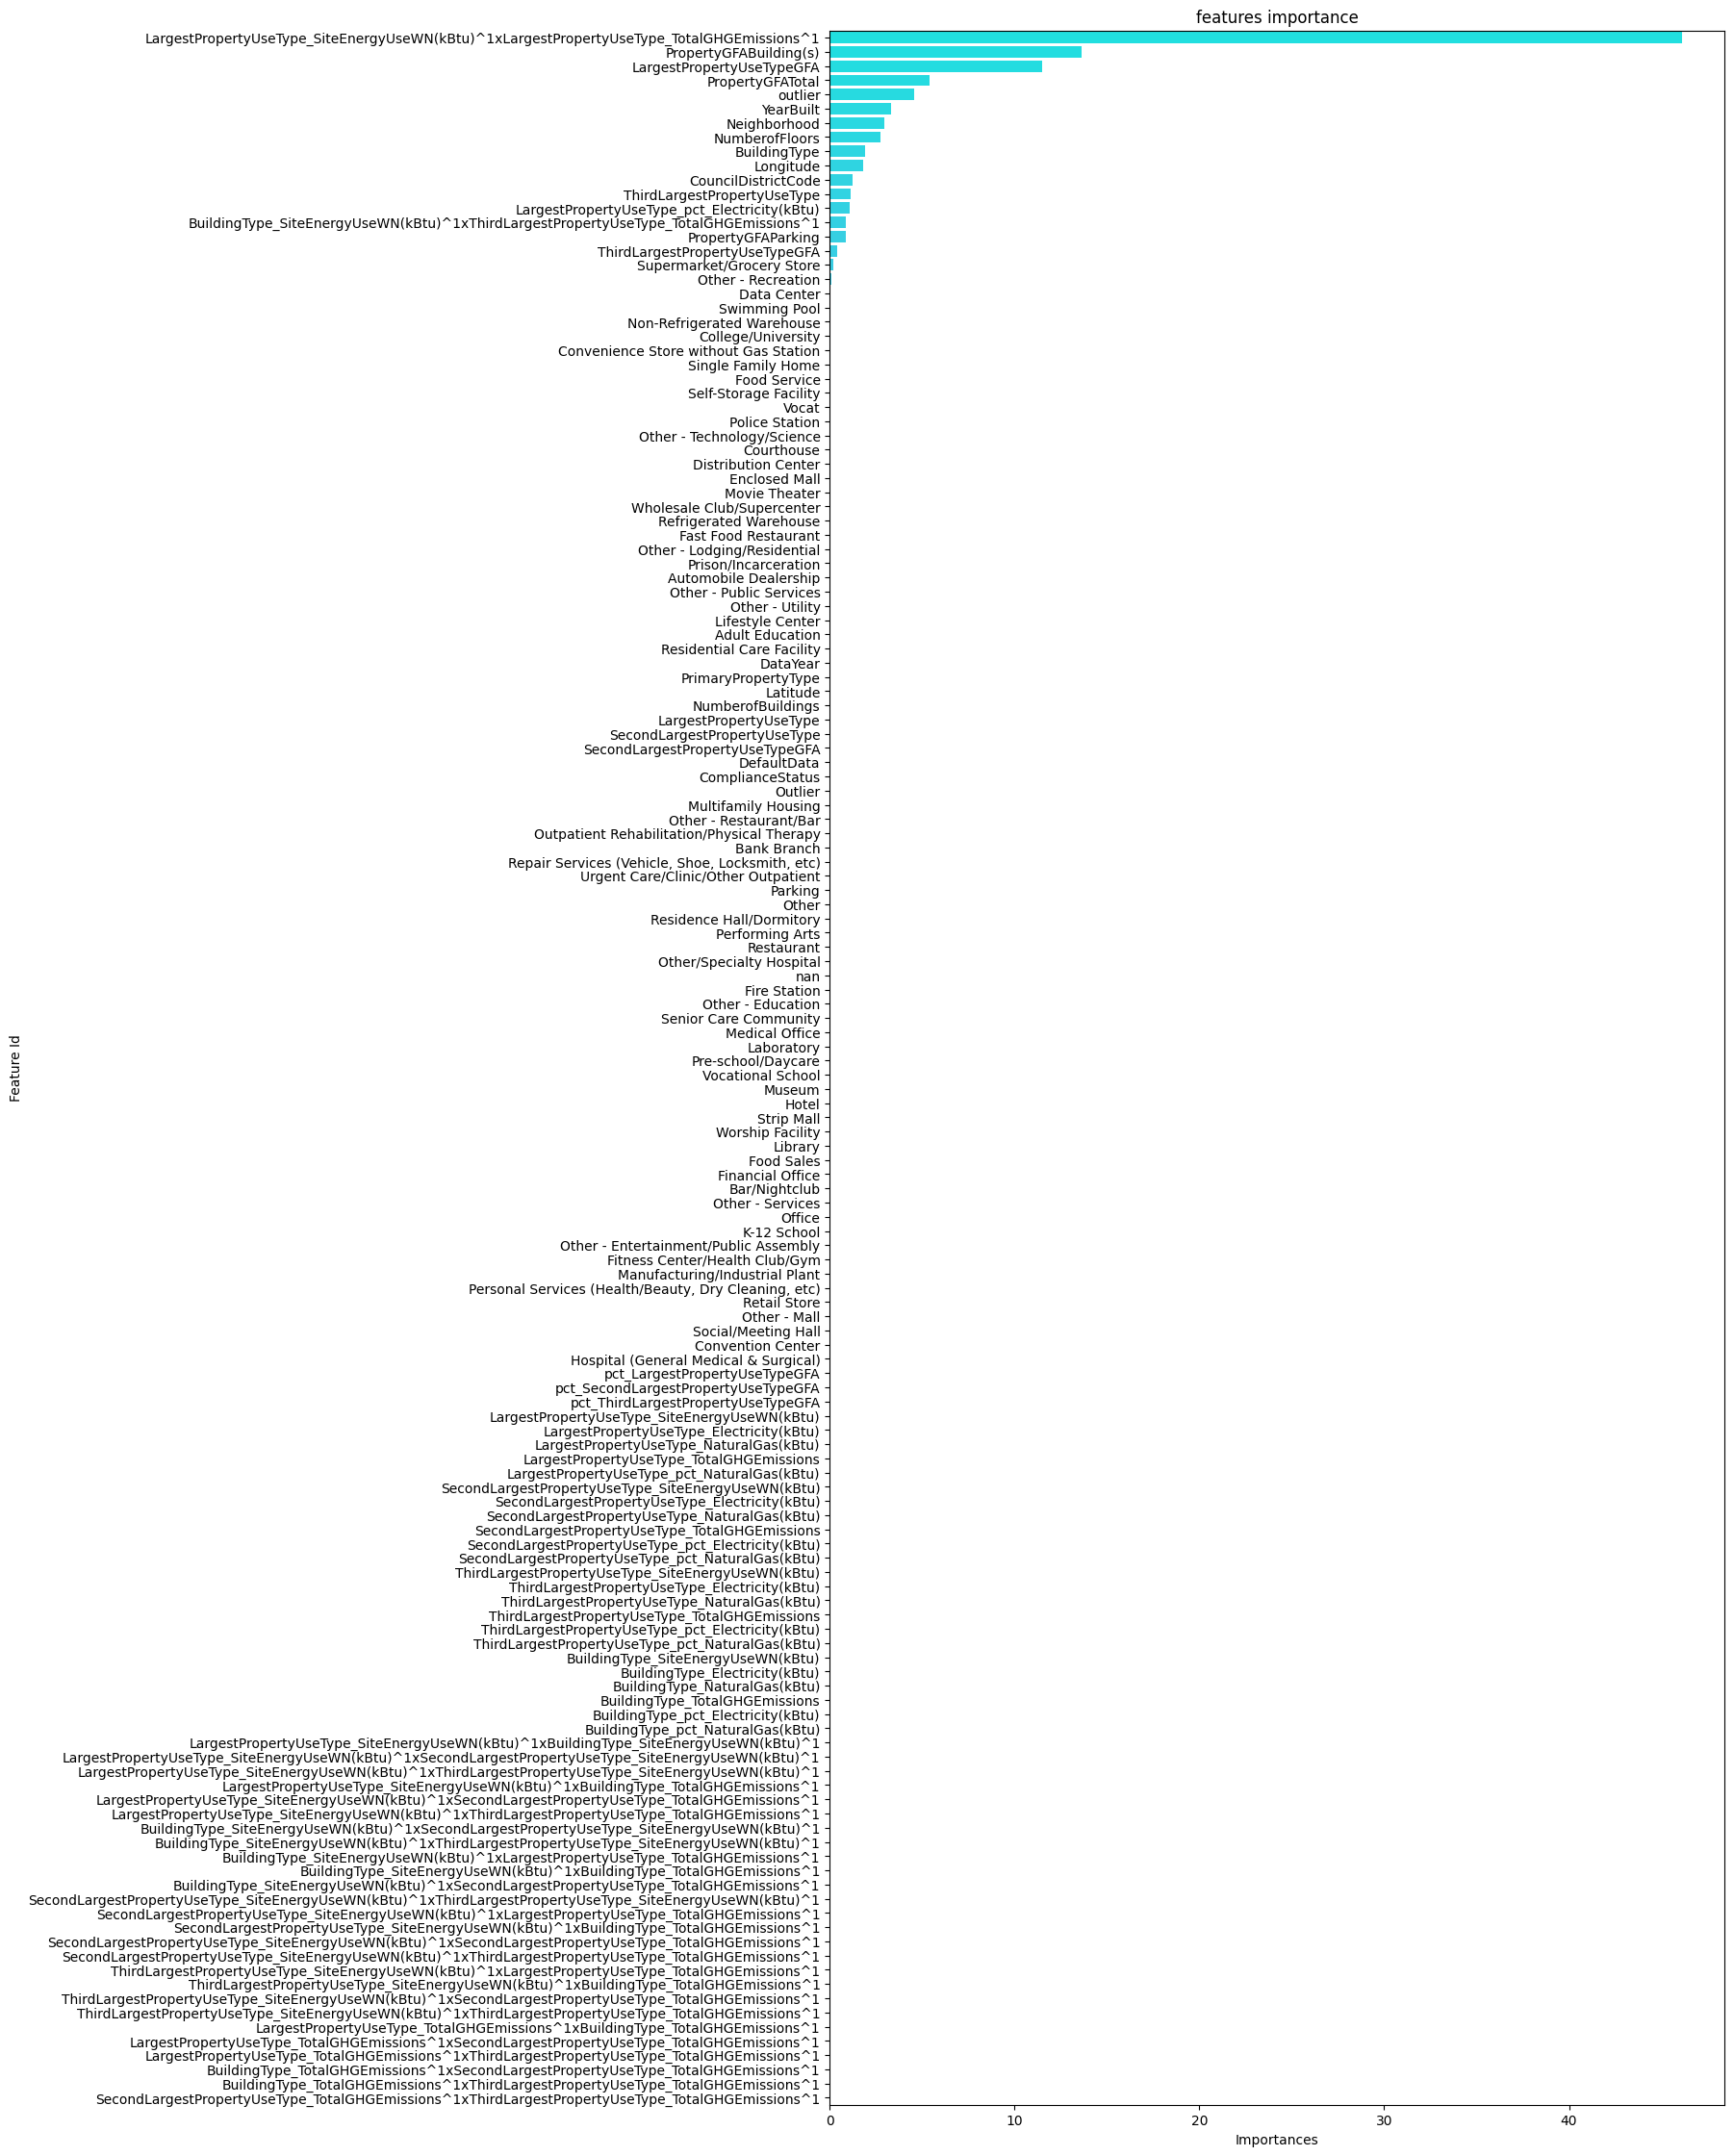

In [106]:
# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 28));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');

---

---

### 📌 Nom des features sélectionnées :

---

In [107]:
print('Selected features indices:', summary['selected_features'])
print('Selected features names:', summary['selected_features_names'])

Selected features indices: [1, 3, 4, 6, 7, 9, 10, 11, 12, 14, 17, 18, 23, 24, 25, 27, 28, 30, 31, 32, 34, 36, 37, 38, 43, 44, 47, 48, 49, 50, 56, 58, 62, 63, 66, 69, 70, 72, 73, 75, 76, 79, 81, 88, 90, 98, 121, 130]
Selected features names: ['BuildingType', 'CouncilDistrictCode', 'Neighborhood', 'Longitude', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'Supermarket/Grocery Store', 'Other - Restaurant/Bar', 'Single Family Home', 'Self-Storage Facility', 'Convenience Store without Gas Station', 'Other - Public Services', 'Other - Technology/Science', 'Adult Education', 'Fast Food Restaurant', 'Other - Lodging/Residential', 'Courthouse', 'Lifestyle Center', 'Movie Theater', 'Enclosed Mall', 'Non-Refrigerated Warehouse', 'nan', 'Fire Station', 'Refrigerated Warehouse', 'Vocational School', 'Distribution Center', 'Vocat', 'Data Center', 'Prison/

---

### 📌 Nom des features supprimées :

---

In [108]:
print('Eliminated features indices:', summary['eliminated_features'])
print('Eliminated features names:', summary['eliminated_features_names'])

Eliminated features indices: [140, 94, 122, 89, 97, 127, 96, 20, 95, 13, 118, 123, 135, 132, 100, 103, 141, 105, 0, 99, 129, 119, 92, 136, 5, 125, 134, 137, 101, 109, 143, 59, 91, 39, 133, 8, 104, 21, 131, 15, 102, 54, 19, 110, 108, 107, 71, 128, 40, 120, 139, 126, 145, 124, 106, 113, 22, 117, 16, 46, 142, 57, 114, 111, 74, 52, 84, 115, 138, 93, 112, 53, 77, 35, 68, 67, 26, 85, 116, 78, 64, 2, 86, 42, 144, 83, 80, 45, 41, 82, 33, 29, 51, 87, 65, 61, 60, 55]
Eliminated features names: ['LargestPropertyUseType_TotalGHGEmissions^1xBuildingType_TotalGHGEmissions^1', 'LargestPropertyUseType_SiteEnergyUseWN(kBtu)', 'LargestPropertyUseType_SiteEnergyUseWN(kBtu)^1xBuildingType_TotalGHGEmissions^1', 'Hospital (General Medical & Surgical)', 'LargestPropertyUseType_TotalGHGEmissions', 'BuildingType_SiteEnergyUseWN(kBtu)^1xLargestPropertyUseType_TotalGHGEmissions^1', 'LargestPropertyUseType_NaturalGas(kBtu)', 'ComplianceStatus', 'LargestPropertyUseType_Electricity(kBtu)', 'LargestPropertyUseType',

---

In [150]:
feature_names = summary['selected_features_names']
X = df[feature_names]

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [151]:

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [152]:
# importing Pool
from catboost import Pool

#feature_names = X[summary['selected_features_names']].columns
#feature_names = ['F{}'.format(i) for i in range(X.shape[1])]

#Creating pool object for train dataset. we give information of categorical fetures to parameter cat_features
train_pool = Pool(data=train_X,
                  label=train_y,
                  #cat_features=cat_features,
                  feature_names=feature_names,
                 )
#Creating pool object for test dataset
test_pool = Pool(data=test_X,
                  label=test_y,
                  #cat_features=cat_features,
                  feature_names=feature_names,
                 )

In [157]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

model = CatBoostRegressor(iterations=7500, random_seed=51)
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select= '0-47',
    #features_for_select='0-99',
    num_features_to_select=39,
    steps=39,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    #train_final_model=True,
    logging_level='Silent',
    plot=True
)

The number of features selection steps (39) is greater than the number of features to eliminate (9). The number of steps was reduced to 9.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [158]:
model.get_feature_importance(prettified=True).head(39)

Feature Id  Importances
0   LargestPropertyUseType_SiteEnergyUseWN(kBtu)^1...    42.308441
1                           LargestPropertyUseTypeGFA    15.068009
2                              PropertyGFABuilding(s)    12.180641
3                                    PropertyGFATotal     6.309288
4                                             outlier     5.010524
5                                           YearBuilt     3.150755
6                                        Neighborhood     2.542436
7                                           Longitude     2.518762
8                                      NumberofFloors     2.015677
9                                        BuildingType     1.824859
10                                CouncilDistrictCode     1.607038
11                        ThirdLargestPropertyUseType     1.297759
12       LargestPropertyUseType_pct_Electricity(kBtu)     1.178205
13  BuildingType_SiteEnergyUseWN(kBtu)^1xThirdLarg...     0.936815
14                                 PropertyGFAParking     0.844415
15                     ThirdLargestPropertyUseTypeGFA     0.706075
16                          Supermarket/Grocery Store     0.185577
17                                        Data Center     0.099513
18                                 Other - Recreation     0.084661
19                                      Swimming Pool     0.045403
20                         Non-Refrigerated Warehouse     0.024477
21              Convenience Store without Gas Station     0.018397
22                                 College/University     0.013659
23                             Other - Restaurant/Bar     0.008545
24                                       Food Service     0.007581
25                              Self-Storage Facility     0.005853
26                            Other - Public Services     0.001949
27                              Automobile Dealership     0.001293
28                                              Vocat     0.000980
29                         Wholesale Club/Supercenter     0.000930
30                             Refrigerated Warehouse     0.000548
31                        Other - Lodging/Residential     0.000503
32                                      Movie Theater     0.000165
33                                      Enclosed Mall     0.000130
34                                    Other - Utility     0.000058
35                                       Fire Station     0.000034
36                          Residential Care Facility     0.000032
37                                  Vocational School     0.000013
38                                 Single Family Home     0.000000

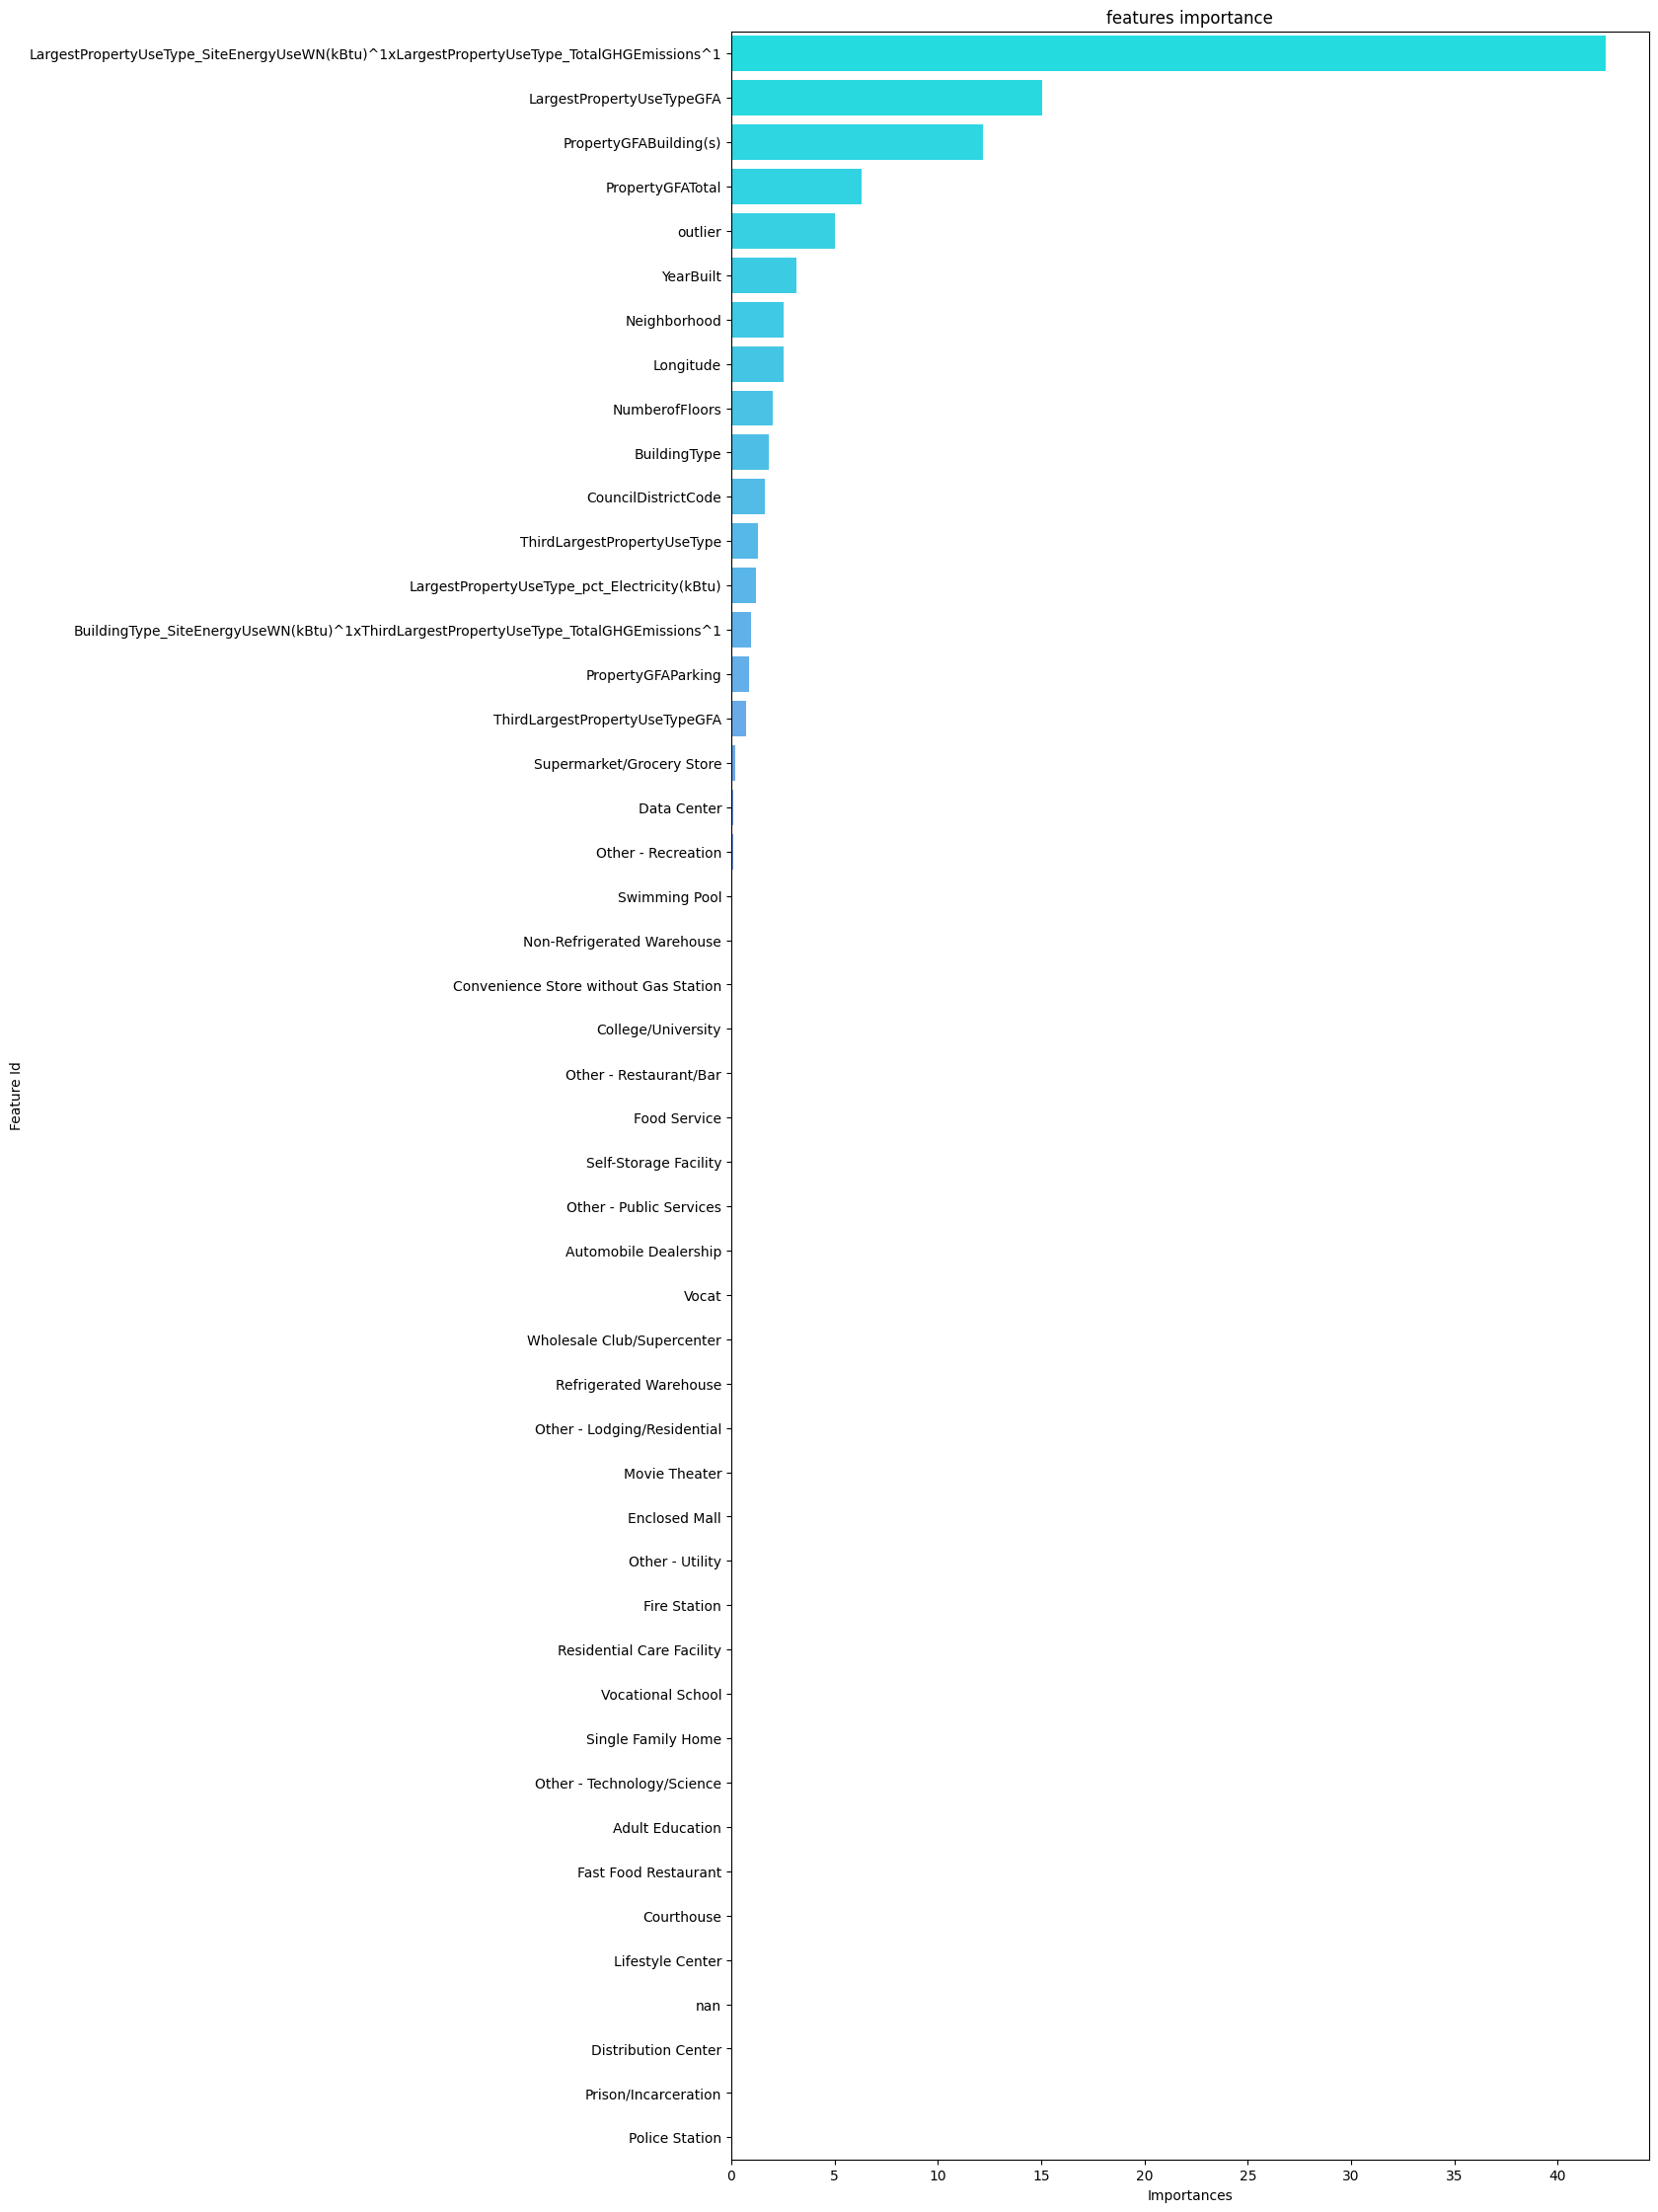

In [159]:
# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 28));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool");
plt.title('features importance');

In [160]:
print('Selected features indices:', summary['selected_features'])
print('Selected features names:', summary['selected_features_names'])

Selected features indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 21, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47]
Selected features names: ['BuildingType', 'CouncilDistrictCode', 'Neighborhood', 'Longitude', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'Supermarket/Grocery Store', 'Other - Restaurant/Bar', 'Self-Storage Facility', 'Convenience Store without Gas Station', 'Other - Public Services', 'Other - Lodging/Residential', 'Movie Theater', 'Enclosed Mall', 'Non-Refrigerated Warehouse', 'nan', 'Fire Station', 'Refrigerated Warehouse', 'Vocational School', 'Vocat', 'Data Center', 'Swimming Pool', 'College/University', 'Residential Care Facility', 'Other - Recreation', 'Other - Utility', 'Automobile Dealership', 'Food Service', 'Wholesale Club/Supercenter', 'outlier', 'LargestPro

In [161]:
print('Eliminated features indices:', summary['eliminated_features'])
print('Eliminated features names:', summary['eliminated_features_names'])

Eliminated features indices: [31, 23, 22, 14, 34, 39, 18, 19, 20]
Eliminated features names: ['Distribution Center', 'Lifestyle Center', 'Courthouse', 'Single Family Home', 'Prison/Incarceration', 'Police Station', 'Other - Technology/Science', 'Adult Education', 'Fast Food Restaurant']


---
---

In [162]:
import optuna

---

# Tuning Hyperparamétrique !

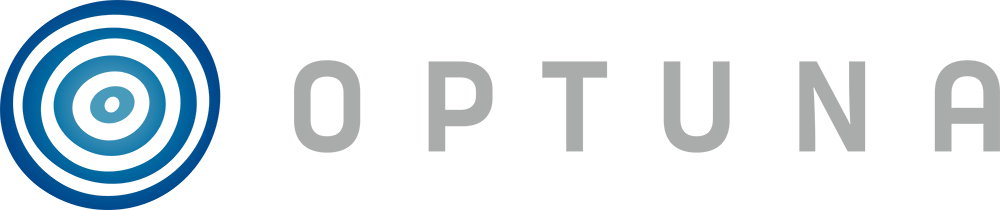

## ⚡ Utilisation Mémoire Expérimentale, modèle ré-entrainable à l'infini

---

#### 📌 Import des librairies

In [163]:
import sys
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error, r2_score

In [379]:
pip install --upgrade optuna

Note: you may need to restart the kernel to use updated packages.


In [176]:
feature_names = summary['selected_features_names']
X = df[feature_names]

In [177]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [178]:
X = pd.DataFrame(X, columns = feature_names)

In [179]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

---

## Étude 1 : CatBoost sans noeuds profonds

---

#### 📌 Déclaration de l'étude et du lieu de stockage

In [192]:
import logging

# Add stream handler of stdout to show the messages
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

###########################################################################

# - Sélection de l'étude souhaitée -

study_name = "TotGHG_CAT_2_03"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name,
                            direction = "minimize",
                            storage=storage_name,
                            load_if_exists=True,
                            sampler = TPESampler(),
                            pruner = optuna.pruners.HyperbandPruner(),
                           )

[I 2023-05-29 01:01:05,509] A new study created in RDB with name: TotGHG_CAT_2_03


#### 📌 Déclaration de fonction d'étude et du modèle

In [193]:
# -------------------------------------------------- Catboost --------------------------------------------------

categorical_features_indices = np.where(X.dtypes != np.float)[0] # cat_idx
from optuna.pruners import HyperbandPruner
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
from catboost import CatBoostRegressor
import optuna

def objective(trial):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)
    
    param = {
        "loss_function" : trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.003, 0.1),   
        "n_estimators":  2500,
        #'rsm': trial.suggest_uniform('rsm', 0.3, 1.0),
        #'subsample': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 0.0001, 10),
        "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth" : trial.suggest_int("depth", 3, 10),
        "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 300),
        "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 20),
        "random_strength" : trial.suggest_float('random_strength', low=0.1, high=20, step=0.01),
        "random_state" : 1,
           }
    
    cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
        # Conditional Hyper-Parameters
        
        # PS : J'ai retiré cette ligne car elle ne fournissait pas les meilleurs scores + pb pour les graphiques
        #if param["bootstrap_type"] == "Bayesian":
            #param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        if param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
        #pruning_callback = optuna.integration.CatBoostPruningCallback(trial, "RMSE")

        reg = CatBoostRegressor(**param,
                                cat_features = categorical_features_indices,
                                verbose=0)
        
        reg.fit(X_train,
                y_train,
                eval_set = [(X_test, y_test)],
                verbose = 0,
                early_stopping_rounds = 80,
                #callbacks=[pruning_callback]
               )
        
        #pruning_callback.check_pruned()
    
        preds = reg.predict(X_test)
        
        mse = mean_squared_error(y_test, preds)
        cv_scores[idx] = np.sqrt(mse)
        #cv_scores[idx] = r2_score(y_test_out, preds)
        
        return np.mean(cv_scores)

C:\Users\E069868\AppData\Local\Temp\ipykernel_15344\4120704984.py:3: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



#### 📌 Réglage de la tête de recherche et lancement de l'étude

In [194]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

study = optuna.create_study(study_name = study_name,
                            storage = storage_name,
                            load_if_exists = True,
                            sampler = TPESampler(),
                            direction = "minimize",
                            pruner = optuna.pruners.HyperbandPruner(),
                           )
study.optimize(objective, n_trials = 200, timeout = 1 * 3600)


# Calculating the pruned and completed trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

C:\Users\E069868\AppData\Local\Temp\ipykernel_15344\2052173943.py:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

[I 2023-05-29 01:01:08,046] Using an existing study with name 'TotGHG_CAT_2_03' instead of creating a new one.
[I 2023-05-29 01:01:12,303] Trial 0 finished with value: 35.328040749421476 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.06519077418277817, 'l2_leaf_reg': 4.952080200931654, 'colsample_bylevel': 0.03395601117868757, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 26, 'one_hot_max_size': 8, 'random_strength': 18.07, 'subsample': 0.8763408424346619}. Best is trial 0 with value: 35.328

[I 2023-05-29 01:04:29,771] Trial 17 finished with value: 42.5332744113759 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.02722342888680742, 'l2_leaf_reg': 5.411275905751945, 'colsample_bylevel': 0.07222112271364091, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 235, 'one_hot_max_size': 12, 'random_strength': 19.98, 'subsample': 0.7458601106564913}. Best is trial 12 with value: 26.341012921211227.
[I 2023-05-29 01:04:33,797] Trial 18 finished with value: 49.50882901891691 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.009575899183403278, 'l2_leaf_reg': 7.438966215939527, 'colsample_bylevel': 0.05077586131949992, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 137, 'one_hot_max_size': 17, 'random_strength': 12.24, 'subsample': 0.478927616109032}. Best is trial 12 with value: 26.341012921211227.
[I 2023-05-29 01:04:54,045] Trial 19 finished with value: 40.69781019463217 and par

[I 2023-05-29 01:07:28,205] Trial 35 finished with value: 30.914016350250144 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.055145728897698136, 'l2_leaf_reg': 4.862090401419723, 'colsample_bylevel': 0.07735553021465222, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 184, 'one_hot_max_size': 10, 'random_strength': 4.779999999999999, 'subsample': 0.9221613612455807}. Best is trial 23 with value: 25.39829955863948.
[I 2023-05-29 01:07:34,841] Trial 36 finished with value: 26.032774255513765 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04228671834101116, 'l2_leaf_reg': 4.145575770229456, 'colsample_bylevel': 0.08527549478063859, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 152, 'one_hot_max_size': 12, 'random_strength': 9.33}. Best is trial 23 with value: 25.39829955863948.
[I 2023-05-29 01:07:37,046] Trial 37 finished with value: 34.4443775114792 and parameters: {'loss_functi

[I 2023-05-29 01:10:41,405] Trial 54 finished with value: 27.407426128575537 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.056296181719476056, 'l2_leaf_reg': 5.69234285118316, 'colsample_bylevel': 0.07433962733643991, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 247, 'one_hot_max_size': 11, 'random_strength': 11.77, 'subsample': 0.6388375755841394}. Best is trial 23 with value: 25.39829955863948.
[I 2023-05-29 01:10:42,577] Trial 55 finished with value: 37.40021677425728 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04392189080502345, 'l2_leaf_reg': 6.289943967810407, 'colsample_bylevel': 0.08505844636493244, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 258, 'one_hot_max_size': 14, 'random_strength': 9.72, 'subsample': 0.7832636845530503}. Best is trial 23 with value: 25.39829955863948.
[I 2023-05-29 01:10:54,977] Trial 56 finished with value: 27.661091940563068 and par

[I 2023-05-29 01:12:29,767] Trial 72 finished with value: 26.574205614463136 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.05724597412580326, 'l2_leaf_reg': 5.685391480310355, 'colsample_bylevel': 0.09031816720993657, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 12, 'random_strength': 11.42, 'subsample': 0.8344592052674634}. Best is trial 60 with value: 25.02670873341856.
[I 2023-05-29 01:12:35,292] Trial 73 finished with value: 25.637272657681677 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.05315452818003663, 'l2_leaf_reg': 4.985827381190907, 'colsample_bylevel': 0.09322744591949396, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 14, 'random_strength': 10.48, 'subsample': 0.9530241271558372}. Best is trial 60 with value: 25.02670873341856.
[I 2023-05-29 01:12:40,702] Trial 74 finished with value: 25.392561555630287 and para

[I 2023-05-29 01:16:52,659] Trial 90 finished with value: 28.16869229743632 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04791265846952694, 'l2_leaf_reg': 6.159765664635766, 'colsample_bylevel': 0.09759293427620515, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 44, 'one_hot_max_size': 15, 'random_strength': 15.78}. Best is trial 77 with value: 24.896444510640574.
[I 2023-05-29 01:16:59,794] Trial 91 finished with value: 27.37757891935592 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04380856986192584, 'l2_leaf_reg': 4.826014524618548, 'colsample_bylevel': 0.09059375232337095, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 41, 'one_hot_max_size': 11, 'random_strength': 9.67}. Best is trial 77 with value: 24.896444510640574.
[I 2023-05-29 01:17:09,682] Trial 92 finished with value: 26.79375096050682 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.03968793847912514, 'l2_l

[I 2023-05-29 01:20:07,644] Trial 108 finished with value: 27.452551127050764 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.052722506812097454, 'l2_leaf_reg': 5.166762449827104, 'colsample_bylevel': 0.07518222108187927, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 17, 'one_hot_max_size': 12, 'random_strength': 8.08, 'subsample': 0.9682504368597582}. Best is trial 77 with value: 24.896444510640574.
[I 2023-05-29 01:21:22,213] Trial 109 finished with value: 27.88248875178121 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.04973533967044433, 'l2_leaf_reg': 4.979498305126544, 'colsample_bylevel': 0.08094276289194619, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 11, 'random_strength': 6.54, 'subsample': 0.8987941861233635}. Best is trial 77 with value: 24.896444510640574.
[I 2023-05-29 01:21:41,144] Trial 110 finished with value: 25.947614807481138 a

[I 2023-05-29 01:26:16,102] Trial 126 finished with value: 26.381266704018447 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.0637934110349573, 'l2_leaf_reg': 5.268233958483302, 'colsample_bylevel': 0.08653529394043395, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 2, 'one_hot_max_size': 18, 'random_strength': 1.1, 'subsample': 0.9134043361866081}. Best is trial 77 with value: 24.896444510640574.
[I 2023-05-29 01:26:35,454] Trial 127 finished with value: 26.86421686533336 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.05644135183539721, 'l2_leaf_reg': 6.307329288987334, 'colsample_bylevel': 0.08350119618305124, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 15, 'random_strength': 3.24, 'subsample': 0.8868996260975679}. Best is trial 77 with value: 24.896444510640574.
[I 2023-05-29 01:26:41,069] Trial 128 finished with value: 25.372129836203975 and para

[I 2023-05-29 01:28:47,424] Trial 144 finished with value: 24.61342451104199 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.06543428916114995, 'l2_leaf_reg': 3.9907940203420624, 'colsample_bylevel': 0.09705653980766904, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 14, 'random_strength': 9.01, 'subsample': 0.9079598403648022}. Best is trial 138 with value: 24.426594138811534.
[I 2023-05-29 01:28:54,875] Trial 145 finished with value: 26.00504235774514 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.06640959601324123, 'l2_leaf_reg': 4.212833852292586, 'colsample_bylevel': 0.09690047822640262, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 9, 'one_hot_max_size': 15, 'random_strength': 9.93, 'subsample': 0.905698786543762}. Best is trial 138 with value: 24.426594138811534.
[I 2023-05-29 01:29:02,243] Trial 146 finished with value: 24.871680993632953 and pa

[I 2023-05-29 01:31:15,276] Trial 162 finished with value: 26.567583656747797 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.06728497605873052, 'l2_leaf_reg': 3.7461000532706716, 'colsample_bylevel': 0.09972149104709081, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 19, 'random_strength': 6.85, 'subsample': 0.8830547101821338}. Best is trial 154 with value: 22.91267681463772.
[I 2023-05-29 01:31:22,661] Trial 163 finished with value: 25.38433229786181 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07298685616686815, 'l2_leaf_reg': 3.860510765028443, 'colsample_bylevel': 0.09724950953010404, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 18, 'random_strength': 7.95, 'subsample': 0.8908800113844593}. Best is trial 154 with value: 22.91267681463772.
[I 2023-05-29 01:31:30,375] Trial 164 finished with value: 24.58349518447729 and pa

[I 2023-05-29 01:33:28,137] Trial 180 finished with value: 24.256829298353768 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07268290945136925, 'l2_leaf_reg': 3.748152333100997, 'colsample_bylevel': 0.09999948160381603, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 17, 'random_strength': 7.85, 'subsample': 0.8026077358930936}. Best is trial 154 with value: 22.91267681463772.
[I 2023-05-29 01:33:35,630] Trial 181 finished with value: 23.74247133682354 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07492436678848118, 'l2_leaf_reg': 3.7617637157312767, 'colsample_bylevel': 0.09998548963818085, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 17, 'random_strength': 7.83, 'subsample': 0.7991519124308823}. Best is trial 154 with value: 22.91267681463772.
[I 2023-05-29 01:33:42,915] Trial 182 finished with value: 25.694262732824967 and pa

[I 2023-05-29 01:35:33,971] Trial 198 finished with value: 25.3340340947989 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07399264134963457, 'l2_leaf_reg': 3.657964953475048, 'colsample_bylevel': 0.0925966093768984, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 18, 'random_strength': 7.67, 'subsample': 0.759675119654171}. Best is trial 154 with value: 22.91267681463772.
[I 2023-05-29 01:35:41,338] Trial 199 finished with value: 25.007802942688965 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.07019227836294627, 'l2_leaf_reg': 3.8286195554365845, 'colsample_bylevel': 0.09752916319265734, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 28, 'one_hot_max_size': 17, 'random_strength': 6.93, 'subsample': 0.8225270661970607}. Best is trial 154 with value: 22.91267681463772.


  Number of finished trials:  200
  Number of pruned trials:  0
  Number of complete trials:  200


In [195]:
best_params = study.best_params

In [196]:
best_params

{'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'colsample_bylevel': 0.09995021532773131,
 'depth': 7,
 'l2_leaf_reg': 4.2292076286720155,
 'learning_rate': 0.0650090127625372,
 'loss_function': 'RMSE',
 'min_data_in_leaf': 9,
 'one_hot_max_size': 15,
 'random_strength': 8.34,
 'subsample': 0.88250440186588}

In [197]:
categorical_features_indices = np.where(X.dtypes != np.float)[0] # cat_idx
from optuna.pruners import HyperbandPruner
from optuna.integration import CatBoostPruningCallback
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
from catboost import CatBoostRegressor

C:\Users\E069868\AppData\Local\Temp\ipykernel_15344\1180004282.py:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



---

## Score without ENERGYSTARScore :

---

In [198]:
import math
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 51)
optimized_regressor = CatBoostRegressor(**best_params,
                                        #learning_rate=study.best_params['learning_rate'],
                                        #depth = study.best_params["depth"],
                                        #l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        #min_child_samples=study.best_params['min_child_samples'],
                                        #random_strength=study.best_params['random_strength'],
                                        #border_count = study.best_params['border_count'],
                                        #grow_policy='Depthwise',
                                        #eval_metric='RMSE',
                                        #od_type='iter',
                                        #od_wait=25,
                                        iterations=2500,
                                        random_state=1,
                                        logging_level='Silent',
                                        #use_best_model=True,
                                       )
optimized_regressor.fit(X_train, y_train,
                        #early_stopping_rounds= 150
                       )
pred_model_opt_2 = optimized_regressor.predict(X_test)

r2_opt_2 = r2_score(y_test, pred_model_opt_2)
rmse_opt_2 = mean_squared_error(y_test, pred_model_opt_2, squared=False)
mae_opt_2 = mean_absolute_error(y_test, pred_model_opt_2)

print('R2 : ',r2_opt_2)
print('RMSE : ',rmse_opt_2)
print('MAE : ', mae_opt_2)

R2 :  0.9489502015241694
RMSE :  134.2402587314384
MAE :  55.777704065738526


---

## Score with ENERGYSTARScore :

---

In [204]:
import math
X["ENERGYSTARScore"] = recup_ENERGYSTARScore
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 51)
optimized_regressor = CatBoostRegressor(**best_params,
                                        iterations=2500,
                                        random_state=1,
                                        logging_level='Silent',
                                        #use_best_model=True,
                                       )
optimized_regressor.fit(X_train, y_train,
                        #early_stopping_rounds= 150
                       )
pred_model_opt_2 = optimized_regressor.predict(X_test)

r2_opt_2 = r2_score(y_test, pred_model_opt_2)
rmse_opt_2 = mean_squared_error(y_test, pred_model_opt_2, squared=False)
mae_opt_2 = mean_absolute_error(y_test, pred_model_opt_2)

print('R2 : ',r2_opt_2)
print('RMSE : ',rmse_opt_2)
print('MAE : ', mae_opt_2)

R2 :  0.959857692569468
RMSE :  119.03835888351203
MAE :  46.11691579739675


#### 📌 Supression à nouveau de la variable ENERGYSTARScore de notre jeu de données :

In [205]:
X = X.drop(columns=["ENERGYSTARScore"])

---

# --- ⛲ Examiner les résultats de l'étude 1 ⛲ ---

---

#### 📌 DataFrame de stockage des résultats de la tête de recherche

In [206]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df.sort_values(by="value",ascending=True).head(60)

number      value params_boosting_type params_bootstrap_type  \
154     154  22.912677                Plain             Bernoulli   
149     149  23.708715                Plain             Bernoulli   
181     181  23.742471                Plain             Bernoulli   
180     180  24.256829                Plain             Bernoulli   
160     160  24.301692                Plain             Bernoulli   
191     191  24.313623                Plain             Bernoulli   
192     192  24.332780                Plain             Bernoulli   
174     174  24.397500                Plain             Bernoulli   
190     190  24.402915                Plain             Bernoulli   
138     138  24.426594                Plain             Bernoulli   
165     165  24.492612                Plain             Bernoulli   
183     183  24.498455                Plain             Bernoulli   
176     176  24.526124                Plain             Bernoulli   
164     164  24.583495                Plain             Bernoulli   
144     144  24.613425                Plain             Bernoulli   
155     155  24.649743                Plain             Bernoulli   
146     146  24.871681                Plain             Bernoulli   
195     195  24.878396                Plain             Bernoulli   
77       77  24.896445                Plain             Bernoulli   
175     175  24.921740                Plain             Bernoulli   
196     196  24.991476                Plain             Bernoulli   
141     141  24.992581                Plain             Bernoulli   
148     148  25.007020                Plain             Bernoulli   
199     199  25.007803                Plain             Bernoulli   
167     167  25.011241                Plain             Bernoulli   
188     188  25.016565                Plain             Bernoulli   
140     140  25.025008                Plain             Bernoulli   
60       60  25.026709                Plain             Bernoulli   
147     147  25.045949                Plain             Bernoulli   
172     172  25.054091                Plain             Bernoulli   
193     193  25.064208                Plain             Bernoulli   
177     177  25.077861                Plain             Bernoulli   
139     139  25.103183                Plain             Bernoulli   
121     121  25.114149                Plain             Bernoulli   
157     157  25.141499                Plain             Bernoulli   
194     194  25.155357                Plain             Bernoulli   
95       95  25.224489                Plain             Bernoulli   
166     166  25.225919                Plain             Bernoulli   
143     143  25.240008                Plain             Bernoulli   
158     158  25.280429                Plain             Bernoulli   
168     168  25.310349                Plain             Bernoulli   
198     198  25.334034                Plain             Bernoulli   
184     184  25.365171                Plain             Bernoulli   
128     128  25.372130                Plain             Bernoulli   
163     163  25.384332                Plain             Bernoulli   
74       74  25.392562                Plain             Bernoulli   
23       23  25.398300                Plain             Bernoulli   
179     179  25.429916                Plain             Bernoulli   
169     169  25.436457                Plain             Bernoulli   
185     185  25.451063                Plain             Bernoulli   
52       52  25.589136                Plain             Bernoulli   
173     173  25.616627                Plain             Bernoulli   
73       73  25.637273                Plain             Bernoulli   
111     111  25.641856                Plain             Bernoulli   
136     136  25.663019                Plain                   MVS   
182     182  25.694263                Plain             Bernoulli   
151     151  25.704314                Plain             Bernoulli   
152

---

# --- 👨‍💻 Récupération des détails techniques des modèles créés 👨‍💻 ---

---

#### 📌 Meilleur réglage hyperparamétrique

In [207]:
print("Best params: ", study.best_params)

Best params:  {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.09995021532773131, 'depth': 7, 'l2_leaf_reg': 4.2292076286720155, 'learning_rate': 0.0650090127625372, 'loss_function': 'RMSE', 'min_data_in_leaf': 9, 'one_hot_max_size': 15, 'random_strength': 8.34, 'subsample': 0.88250440186588}


#### 📌 Meilleur résultat obtenu dans la métrique de recherche

In [208]:
print("Best value: ", study.best_value)

Best value:  22.91267681463772


#### 📌 Détails du meilleur réglage hyperparamétrique

In [209]:
print("Best Trial: ", study.best_trial)

Best Trial:  FrozenTrial(number=154, state=TrialState.COMPLETE, values=[22.91267681463772], datetime_start=datetime.datetime(2023, 5, 29, 1, 29, 55, 410028), datetime_complete=datetime.datetime(2023, 5, 29, 1, 30, 2, 955385), params={'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.09995021532773131, 'depth': 7, 'l2_leaf_reg': 4.2292076286720155, 'learning_rate': 0.0650090127625372, 'loss_function': 'RMSE', 'min_data_in_leaf': 9, 'one_hot_max_size': 15, 'random_strength': 8.34, 'subsample': 0.88250440186588}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'boosting_type': CategoricalDistribution(choices=('Ordered', 'Plain')), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian', 'Bernoulli', 'MVS')), 'colsample_bylevel': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=0.0001, step=None), 'lea

#### 📌 Liste des études réalisées

In [210]:
print("Trials: ", study.trials)

Trials:  [FrozenTrial(number=0, state=TrialState.COMPLETE, values=[35.328040749421476], datetime_start=datetime.datetime(2023, 5, 29, 1, 1, 8, 62181), datetime_complete=datetime.datetime(2023, 5, 29, 1, 1, 12, 256535), params={'loss_function': 'RMSE', 'learning_rate': 0.06519077418277817, 'l2_leaf_reg': 4.952080200931654, 'colsample_bylevel': 0.03395601117868757, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 26, 'one_hot_max_size': 8, 'random_strength': 18.07, 'subsample': 0.8763408424346619}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'loss_function': CategoricalDistribution(choices=('RMSE', 'MAE')), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.003, step=None), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=0.0001, step=None), 'colsample_bylevel': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'depth': IntDistribution(high=10, log=False, low=3, step=1), 'boosting_type': 

In [211]:
optuna.visualization.plot_edf(study)

In [212]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [213]:
optuna.visualization.plot_slice(study)

In [214]:
fig = optuna.visualization.plot_contour(study, params=["l2_leaf_reg", "learning_rate"])
fig.show()

In [215]:
fig = optuna.visualization.plot_contour(study, params=["min_data_in_leaf", "random_strength"])
fig.show()

In [216]:
fig = optuna.visualization.plot_contour(study, params=["colsample_bylevel", "depth"])
fig.show()

---
---

## Étude 2 : CatBoost avec noeuds profonds

---

In [217]:
import logging

# Add stream handler of stdout to show the messages
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

###########################################################################

# - Sélection de l'étude souhaitée -

study_name = "TotGHG_CAT_1_01"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name,
                            direction = "minimize",
                            storage=storage_name,
                            load_if_exists=True,
                            sampler = TPESampler(),
                            pruner = optuna.pruners.HyperbandPruner(),
                           )

[I 2023-05-29 01:49:28,098] A new study created in RDB with name: TotGHG_CAT_1_01


In [218]:
import optuna
from optuna.integration import CatBoostPruningCallback
from sklearn.metrics import mean_squared_error

def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.07, log=True)
    param['depth'] = trial.suggest_int('depth', 8, 10)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg',low=1.1, high=8.5, step=0.0001)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [3, 4, 5, 6 ,7, 8, 10, 14, 16, 18, 22, 24, 28, 30, 32, 36, 48, 64, 86, 92, 128, 148, 184 , 228, 256, 292, 328, 384])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 2500
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 25
    param['random_state'] = 1
    param['logging_level'] = 'Silent'
    param['random_strength'] = trial.suggest_float('random_strength', low=0.1, high=20, step=0.01)
    #param['border_count'] = trial.suggest_float('border_count', low=256, high=512, step=64)
    #param['permutation_count'] = trial.suggest_float('permutation_count',low=1, high=10, step=1)
    #param['task_type'] = 'GPU'

    regressor = CatBoostRegressor(**param)
    
    #pruning_callback = CatBoostPruningCallback(trial, "Accuracy")

    regressor.fit(X_train, y_train,early_stopping_rounds=80,
                  #callbacks=[pruning_callback]
                 )
    
    # evoke pruning manually.
    #pruning_callback.check_pruned()
    
    loss = mean_squared_error(y_test, regressor.predict(X_test.copy()), squared=False)
    return loss

In [219]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

study = optuna.create_study(study_name = study_name,
                            storage = storage_name,
                            load_if_exists = True,
                            sampler = TPESampler(),
                            direction = "minimize",
                            pruner = optuna.pruners.HyperbandPruner(),
                           )
study.optimize(objective, n_trials = 200, timeout = 1 * 3600)

# Calculating the pruned and completed trials
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

C:\Users\E069868\AppData\Local\Temp\ipykernel_15344\3668033497.py:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

[I 2023-05-29 01:49:47,772] Using an existing study with name 'TotGHG_CAT_1_01' instead of creating a new one.
[I 2023-05-29 01:50:01,027] Trial 0 finished with value: 159.55328740903022 and parameters: {'learning_rate': 0.004910071415199086, 'depth': 8, 'l2_leaf_reg': 4.796900000000001, 'min_child_samples': 28, 'random_strength': 12.26}. Best is trial 0 with value: 159.55328740903022.
[I 2023-05-29 01:50:09,493] Trial 1 finished with value: 310.36528318132184 and parameters: {'learning_rate': 0.002701685755188835, 'depth': 8, 'l2_leaf_reg': 6.3041,

[I 2023-05-29 01:56:52,152] Trial 27 finished with value: 127.52437116558926 and parameters: {'learning_rate': 0.052291046693672176, 'depth': 8, 'l2_leaf_reg': 7.8179, 'min_child_samples': 292, 'random_strength': 16.76}. Best is trial 25 with value: 104.78888636149745.
[I 2023-05-29 01:57:00,677] Trial 28 finished with value: 117.87282265349735 and parameters: {'learning_rate': 0.0276249241832353, 'depth': 8, 'l2_leaf_reg': 7.1745, 'min_child_samples': 30, 'random_strength': 19.78}. Best is trial 25 with value: 104.78888636149745.
[I 2023-05-29 01:57:20,403] Trial 29 finished with value: 103.5283749619664 and parameters: {'learning_rate': 0.035555915449931794, 'depth': 8, 'l2_leaf_reg': 5.3323, 'min_child_samples': 5, 'random_strength': 14.76}. Best is trial 29 with value: 103.5283749619664.
[I 2023-05-29 01:57:38,685] Trial 30 finished with value: 113.65645378472186 and parameters: {'learning_rate': 0.03545670520551034, 'depth': 8, 'l2_leaf_reg': 8.130600000000001, 'min_child_samples'

[I 2023-05-29 02:02:40,707] Trial 56 finished with value: 111.76655340810234 and parameters: {'learning_rate': 0.02163987813372428, 'depth': 8, 'l2_leaf_reg': 2.9273000000000002, 'min_child_samples': 18, 'random_strength': 18.57}. Best is trial 50 with value: 100.18711028069775.
[I 2023-05-29 02:02:53,470] Trial 57 finished with value: 104.3961225851528 and parameters: {'learning_rate': 0.027586949530194704, 'depth': 8, 'l2_leaf_reg': 2.0202, 'min_child_samples': 18, 'random_strength': 14.13}. Best is trial 50 with value: 100.18711028069775.
[I 2023-05-29 02:03:01,393] Trial 58 finished with value: 112.6042168758938 and parameters: {'learning_rate': 0.02598652807633888, 'depth': 8, 'l2_leaf_reg': 2.4585, 'min_child_samples': 128, 'random_strength': 13.88}. Best is trial 50 with value: 100.18711028069775.
[I 2023-05-29 02:03:14,858] Trial 59 finished with value: 103.73676163552356 and parameters: {'learning_rate': 0.01762813988693518, 'depth': 8, 'l2_leaf_reg': 1.9771, 'min_child_sample

[I 2023-05-29 02:09:15,795] Trial 85 finished with value: 112.62886788770014 and parameters: {'learning_rate': 0.02415324368672947, 'depth': 8, 'l2_leaf_reg': 3.8953, 'min_child_samples': 3, 'random_strength': 11.56}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:09:24,416] Trial 86 finished with value: 115.27580117873632 and parameters: {'learning_rate': 0.015160037236645716, 'depth': 8, 'l2_leaf_reg': 4.2636, 'min_child_samples': 48, 'random_strength': 19.110000000000003}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:09:41,432] Trial 87 finished with value: 118.98296276713724 and parameters: {'learning_rate': 0.03356624651618381, 'depth': 8, 'l2_leaf_reg': 1.5342000000000002, 'min_child_samples': 7, 'random_strength': 15.78}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:10:01,718] Trial 88 finished with value: 112.9103060158792 and parameters: {'learning_rate': 0.019361394133785906, 'depth': 8, 'l2_leaf_reg': 2.8353, 'min_chi

[I 2023-05-29 02:15:07,998] Trial 114 finished with value: 111.48232464943668 and parameters: {'learning_rate': 0.03570071321900352, 'depth': 8, 'l2_leaf_reg': 3.8303000000000003, 'min_child_samples': 36, 'random_strength': 13.53}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:15:17,678] Trial 115 finished with value: 105.80997271719873 and parameters: {'learning_rate': 0.048328236647276215, 'depth': 8, 'l2_leaf_reg': 4.1626, 'min_child_samples': 36, 'random_strength': 12.54}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:15:26,699] Trial 116 finished with value: 111.93305856189012 and parameters: {'learning_rate': 0.05570727245479256, 'depth': 8, 'l2_leaf_reg': 3.3547000000000002, 'min_child_samples': 36, 'random_strength': 14.56}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:15:37,521] Trial 117 finished with value: 112.90633726767028 and parameters: {'learning_rate': 0.03892775794458262, 'depth': 9, 'l2_leaf_reg': 3.148700000

[I 2023-05-29 02:20:44,785] Trial 143 finished with value: 105.23067007370628 and parameters: {'learning_rate': 0.016486481456965362, 'depth': 8, 'l2_leaf_reg': 1.1966, 'min_child_samples': 16, 'random_strength': 15.97}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:20:54,152] Trial 144 finished with value: 117.90375752173442 and parameters: {'learning_rate': 0.014122753972984537, 'depth': 8, 'l2_leaf_reg': 4.1466, 'min_child_samples': 36, 'random_strength': 14.7}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:21:01,956] Trial 145 finished with value: 112.2473872446947 and parameters: {'learning_rate': 0.017374368352491166, 'depth': 8, 'l2_leaf_reg': 1.6572, 'min_child_samples': 92, 'random_strength': 13.86}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:21:15,024] Trial 146 finished with value: 102.36719534773484 and parameters: {'learning_rate': 0.04054725057591616, 'depth': 8, 'l2_leaf_reg': 1.5345, 'min_child_samples': 16, 'r

[I 2023-05-29 02:26:34,128] Trial 172 finished with value: 109.28018269072614 and parameters: {'learning_rate': 0.016286103066656874, 'depth': 8, 'l2_leaf_reg': 1.3884, 'min_child_samples': 16, 'random_strength': 15.35}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:26:46,434] Trial 173 finished with value: 105.6890570465804 and parameters: {'learning_rate': 0.017818213728165756, 'depth': 8, 'l2_leaf_reg': 5.3956, 'min_child_samples': 16, 'random_strength': 14.87}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:26:55,089] Trial 174 finished with value: 107.38076275835098 and parameters: {'learning_rate': 0.02594201892960952, 'depth': 8, 'l2_leaf_reg': 3.9264, 'min_child_samples': 36, 'random_strength': 15.51}. Best is trial 66 with value: 98.18249884717218.
[I 2023-05-29 02:27:04,652] Trial 175 finished with value: 109.34570813282244 and parameters: {'learning_rate': 0.022016583349340334, 'depth': 8, 'l2_leaf_reg': 1.727, 'min_child_samples': 64, 'r

  Number of finished trials:  200
  Number of pruned trials:  0
  Number of complete trials:  200


In [220]:
import math
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 51)

optimized_regressor = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth = study.best_params["depth"],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        random_strength=study.best_params['random_strength'],
                                        #border_count = study.best_params['border_count'],
                                        grow_policy='Depthwise',
                                        iterations=2500,
                                        eval_metric='RMSE',
                                        #od_type='iter',
                                        od_wait=25,
                                        random_state=1,
                                        logging_level='Silent',
                                        #use_best_model=True,
                                       )
optimized_regressor.fit(X_train, y_train,
                        #early_stopping_rounds= 150
                       )
pred_model_opt_2 = optimized_regressor.predict(X_test)

r2_opt_2 = r2_score(y_test, pred_model_opt_2)
rmse_opt_2 = mean_squared_error(y_test, pred_model_opt_2, squared=False)
mae_opt_2 = mean_absolute_error(y_test, pred_model_opt_2)

print('R2 : ',r2_opt_2)
print('RMSE : ',rmse_opt_2)
print('MAE : ', mae_opt_2)

R2 :  0.9530399952091213
RMSE :  128.75076874453887
MAE :  52.19906515170842


In [221]:
import math
X["ENERGYSTARScore"] = recup_ENERGYSTARScore
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 51)

optimized_regressor = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth = study.best_params["depth"],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        random_strength=study.best_params['random_strength'],
                                        #border_count = study.best_params['border_count'],
                                        grow_policy='Depthwise',
                                        iterations=2500,
                                        eval_metric='RMSE',
                                        #od_type='iter',
                                        od_wait=25,
                                        random_state=1,
                                        logging_level='Silent',
                                        #use_best_model=True,
                                       )
optimized_regressor.fit(X_train, y_train,
                        #early_stopping_rounds= 150
                       )
pred_model_opt_2 = optimized_regressor.predict(X_test)

r2_opt_2 = r2_score(y_test, pred_model_opt_2)
rmse_opt_2 = mean_squared_error(y_test, pred_model_opt_2, squared=False)
mae_opt_2 = mean_absolute_error(y_test, pred_model_opt_2)

print('R2 : ',r2_opt_2)
print('RMSE : ',rmse_opt_2)
print('MAE : ', mae_opt_2)

R2 :  0.9726915762511981
RMSE :  98.18249884717218
MAE :  43.58238639280336


---

# --- ⛲ Examiner les résultats de l'étude 1 ⛲ ---

---

In [222]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df.sort_values(by="value",ascending=True).head(60)

number       value  params_depth  params_l2_leaf_reg  \
66       66   98.182499             8              4.2163   
109     109   98.693989             8              3.8109   
107     107   99.721636             8              3.2427   
111     111   99.838001             8              3.5371   
108     108   99.843256             8              3.7747   
50       50  100.187110             8              1.7933   
35       35  100.615218             8              4.5599   
126     126  101.203640             8              3.9034   
151     151  101.655434             8              3.3888   
146     146  102.367195             8              1.5345   
63       63  102.383590             8              1.1344   
79       79  102.439982             8              2.4843   
142     142  102.510171             8              1.2638   
43       43  103.441540             8              3.5291   
29       29  103.528375             8              5.3323   
61       61  103.564941             8              4.1644   
59       59  103.736762             8              1.9771   
190     190  103.838751             8              3.3515   
71       71  103.960412             8              1.4211   
179     179  104.099662             8              1.5610   
106     106  104.111430             8              3.2927   
65       65  104.269896             8              4.5713   
129     129  104.318744             8              3.4447   
57       57  104.396123             8              2.0202   
154     154  104.667624             8              3.4927   
180     180  104.719113             9              2.1274   
25       25  104.788886             8              7.4784   
131     131  104.941953             8              2.9638   
60       60  104.963175             8              1.9928   
143     143  105.230670             8              1.1966   
51       51  105.447853             8              1.6562   
72       72  105.460709             8              5.7860   
140     140  105.643681             8              4.4492   
150     150  105.654870             8              3.6380   
173     173  105.689057             8              5.3956   
98       98  105.711167             8              5.4300   
69       69  105.740608             8              4.2414   
115     115  105.809973             8              4.1626   
82       82  105.844683             8              3.3997   
118     118  105.867479             8              3.8044   
96       96  105.968696             8              1.5542   
127     127  106.196943             8              3.9576   
112     112  106.225922             8              3.0442   
148     148  106.232566             8              1.1001   
67       67  106.363337             9              4.0996   
147     147  106.461934             8              1.4968   
93       93  106.600192             8              1.8856   
64       64  106.610321             8              1.1265   
91       91  107.151120             8              1.1138   
196     196  107.157001             8              3.9777   
188     188  107.261547             8              3.8057   
135     135  107.274881             8              2.1923   
174     174  107.380763             8              3.9264   
141     141  107.385389             8              2.0161   
78       78  107.564148             8              5.2521   
192     192  107.837506             8              2.9227   
119     119  107.847039             8              3.9982   
37       37  107.996689             8              3.4929   
122     122  108.099568             8              3.5843   
160     160  108.164133             8              5.7420   

     params_learning_rate  params_min_child_samples  params_random_strength  \
66               0.032554                         5                   15.48   
109              0.041275                        36                   13.40   
107              0.039748                     

# --- 👨‍💻 Récupération des détails techniques des modèles créés 👨‍💻 ---

In [223]:
print("Best params: ", study.best_params)

Best params:  {'depth': 8, 'l2_leaf_reg': 4.2163, 'learning_rate': 0.03255438779387451, 'min_child_samples': 5, 'random_strength': 15.48}


In [224]:
print("Best value: ", study.best_value)

Best value:  98.18249884717218


In [225]:
print("Best Trial: ", study.best_trial)

Best Trial:  FrozenTrial(number=66, state=TrialState.COMPLETE, values=[98.18249884717218], datetime_start=datetime.datetime(2023, 5, 29, 2, 4, 43, 139250), datetime_complete=datetime.datetime(2023, 5, 29, 2, 5, 1, 644407), params={'depth': 8, 'l2_leaf_reg': 4.2163, 'learning_rate': 0.03255438779387451, 'min_child_samples': 5, 'random_strength': 15.48}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'depth': IntDistribution(high=10, log=False, low=8, step=1), 'l2_leaf_reg': FloatDistribution(high=8.5, log=False, low=1.1, step=0.0001), 'learning_rate': FloatDistribution(high=0.07, log=True, low=0.001, step=None), 'min_child_samples': CategoricalDistribution(choices=(3, 4, 5, 6, 7, 8, 10, 14, 16, 18, 22, 24, 28, 30, 32, 36, 48, 64, 86, 92, 128, 148, 184, 228, 256, 292, 328, 384)), 'random_strength': FloatDistribution(high=20.0, log=False, low=0.1, step=0.01)}, trial_id=67, value=None)


In [226]:
print("Trials: ", study.trials)

Trials:  [FrozenTrial(number=0, state=TrialState.COMPLETE, values=[159.55328740903022], datetime_start=datetime.datetime(2023, 5, 29, 1, 49, 47, 788334), datetime_complete=datetime.datetime(2023, 5, 29, 1, 50, 0, 986577), params={'learning_rate': 0.004910071415199086, 'depth': 8, 'l2_leaf_reg': 4.796900000000001, 'min_child_samples': 28, 'random_strength': 12.26}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.07, log=True, low=0.001, step=None), 'depth': IntDistribution(high=10, log=False, low=8, step=1), 'l2_leaf_reg': FloatDistribution(high=8.5, log=False, low=1.1, step=0.0001), 'min_child_samples': CategoricalDistribution(choices=(3, 4, 5, 6, 7, 8, 10, 14, 16, 18, 22, 24, 28, 30, 32, 36, 48, 64, 86, 92, 128, 148, 184, 228, 256, 292, 328, 384)), 'random_strength': FloatDistribution(high=20.0, log=False, low=0.1, step=0.01)}, trial_id=1, value=None), FrozenTrial(number=1, state=TrialState.COMPLETE, values=[310.36528318

#### 📌 Installer le Kit Optuna pour afficher des DashBoards intéractifs :

In [375]:
pip install optuna-dashboard

Note: you may need to restart the kernel to use updated packages.


#### 📌 Dashboard intéractif OPTUNA :

In [376]:
# optuna-dashboard sqlite:///example-study.db

#### 📌 Proportion de valeur des scores par rapport au nombre d'études réalisées

In [227]:
optuna.visualization.plot_edf(study)

#### 📌 Pruning et shooting rapide d'optimisation

In [112]:
# optuna.visualization.plot_intermediate_values(study)

#### 📌 Secteurs de recherches hyperparamétriques et résultats :

In [228]:
optuna.visualization.plot_parallel_coordinate(study)

#### 📌 Feature Importance des hyperparamétres :

In [115]:
optuna.visualization.plot_param_importances(study)

TypeError: 'FrozenTrial' object is not iterable

#### 📌 Front de pareto multi-objectif (non utilisé ici, visualisable sur le graph de répartition empirique des scores)

In [31]:
# optuna.visualization.plot_pareto_front(study)

#### 📌 Comportement du réglage hyperparamétrique durant la recherche :

In [229]:
optuna.visualization.plot_slice(study)

---

In [230]:
import matplotlib.pyplot as plt

In [231]:
fig = optuna.visualization.plot_contour(study, params=["l2_leaf_reg", "learning_rate"])
fig.show()

In [232]:
fig = optuna.visualization.plot_contour(study, params=["min_child_samples", "random_strength"])
fig.show()

# 👨‍🚀👩‍🚀 Compte-rendu d'analyses :

---

# 🚀 Plages de recherche optimales détectées :

---

---

# Nouveau secteur de recherche pour optimisation stage 2 avec Sklearn :

---

In [39]:
from sklearn.metrics import mean_absolute_error

In [36]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

# Définir les hyperparamètres à rechercher
param_grid = {
    "loss_function": ["RMSE"],
    "learning_rate": [0.06564651792093319],
    "n_estimators": [1500],
    "l2_leaf_reg": [0.47618659871824187],
    "colsample_bylevel" : [0.07809057562414028],
    "depth": [9,10],
    "boosting_type": ["Plain"],
    "bootstrap_type": ["MVS"],
    "min_data_in_leaf": [17,18],
    "one_hot_max_size": [16],
}

# Définir le modèle CatBoostRegressor
reg = CatBoostRegressor(cat_features=categorical_features_indices, verbose=500)

# Définir la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=cv)

# Exécuter la recherche des meilleurs hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score correspondant
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleur score RMSE : ", -grid_search.best_score_)

0:	learn: 9990823.2973196	total: 3.51ms	remaining: 5.26s
500:	learn: 1313205.6742694	total: 1.61s	remaining: 3.22s
1000:	learn: 658063.4131688	total: 3.36s	remaining: 1.68s
1499:	learn: 396272.1838551	total: 4.78s	remaining: 0us
0:	learn: 10342243.0769142	total: 4.1ms	remaining: 6.14s
500:	learn: 1327911.5206380	total: 1.59s	remaining: 3.17s
1000:	learn: 678890.4987972	total: 3.06s	remaining: 1.53s
1499:	learn: 405392.6212523	total: 4.56s	remaining: 0us
0:	learn: 10294550.8821965	total: 4.28ms	remaining: 6.41s
500:	learn: 1362975.1591210	total: 1.61s	remaining: 3.22s
1000:	learn: 666613.2483408	total: 3.49s	remaining: 1.74s
1499:	learn: 409419.0501743	total: 5.18s	remaining: 0us
0:	learn: 8916957.4798042	total: 1.46ms	remaining: 2.19s
500:	learn: 1340884.8163071	total: 1.64s	remaining: 3.26s
1000:	learn: 666227.5306590	total: 3.17s	remaining: 1.58s
1499:	learn: 397417.3596085	total: 4.78s	remaining: 0us
0:	learn: 10476541.0360642	total: 3.37ms	remaining: 5.04s
500:	learn: 1256443.12388

In [315]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Définir les hyperparamètres à rechercher
param_grid = {
    "loss_function": ["RMSE", "MAE", "R2"],
    "learning_rate": np.linspace(0.075577, 0.094258, num=10),
    "n_estimators": [450],
    "l2_leaf_reg": np.linspace(4.056338, 6.603277, num=10),
    "colsample_bylevel" : np.linspace(0.91885, 0.094416, num=10),
    "depth": [9],
    "boosting_type": ["Plain"],
    "bootstrap_type": ["MVS"],
    "min_data_in_leaf": np.linspace(59, 76, num=10),
    "one_hot_max_size": [12, 13, 14],
}

# Définir le modèle CatBoostRegressor
reg = CatBoostRegressor(cat_features=categorical_features_indices, verbose=500)

# Définir la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Créer l'objet GridSearchCV
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='r2', cv=cv)

# Exécuter la recherche des meilleurs hyperparamètres
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres et le score correspondant
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleur score RMSE : ", -grid_search.best_score_)

0:	learn: 9024182.2742963	total: 18.5ms	remaining: 8.31s
449:	learn: 1101842.1027826	total: 8.12s	remaining: 0us
0:	learn: 10062227.9803039	total: 8.54ms	remaining: 3.83s
449:	learn: 1231989.5185980	total: 8.51s	remaining: 0us
0:	learn: 10127815.8966728	total: 15.3ms	remaining: 6.86s
449:	learn: 1182781.7136511	total: 8.67s	remaining: 0us
0:	learn: 10554941.0901265	total: 17.7ms	remaining: 7.96s
449:	learn: 1159480.9289069	total: 8.22s	remaining: 0us
0:	learn: 10474388.3158348	total: 6.22ms	remaining: 2.79s
449:	learn: 1289843.8050249	total: 8.69s	remaining: 0us
0:	learn: 9024182.2742963	total: 18.2ms	remaining: 8.15s
449:	learn: 1101842.1027826	total: 8.4s	remaining: 0us
0:	learn: 10062227.9803039	total: 6.84ms	remaining: 3.07s
449:	learn: 1231989.5185980	total: 8.99s	remaining: 0us
0:	learn: 10127815.8966728	total: 23ms	remaining: 10.3s
449:	learn: 1182781.7136511	total: 8.46s	remaining: 0us
0:	learn: 10554941.0901265	total: 17.8ms	remaining: 8.01s
449:	learn: 1159480.9289069	total: 

449:	learn: 1182781.7136511	total: 9.41s	remaining: 0us
0:	learn: 10554941.0901265	total: 14.5ms	remaining: 6.52s
449:	learn: 1159480.9289069	total: 8.54s	remaining: 0us
0:	learn: 10474388.3158348	total: 10.3ms	remaining: 4.62s
449:	learn: 1289843.8050249	total: 9.02s	remaining: 0us
0:	learn: 9024182.2742963	total: 14.7ms	remaining: 6.62s
449:	learn: 1101842.1027826	total: 8.86s	remaining: 0us
0:	learn: 10062227.9803039	total: 10.5ms	remaining: 4.72s
449:	learn: 1231989.5185980	total: 8.58s	remaining: 0us
0:	learn: 10127815.8966728	total: 14.9ms	remaining: 6.67s
449:	learn: 1182781.7136511	total: 9.09s	remaining: 0us
0:	learn: 10554941.0901265	total: 20.6ms	remaining: 9.27s
449:	learn: 1159480.9289069	total: 8.28s	remaining: 0us
0:	learn: 10474388.3158348	total: 9.6ms	remaining: 4.31s
449:	learn: 1289843.8050249	total: 9.35s	remaining: 0us
0:	learn: 9024182.2742963	total: 17.2ms	remaining: 7.71s
449:	learn: 1101842.1027826	total: 8.15s	remaining: 0us
0:	learn: 10062227.9803039	total: 1

449:	learn: 1101842.1027826	total: 9.93s	remaining: 0us
0:	learn: 10062227.9803039	total: 8.23ms	remaining: 3.69s
449:	learn: 1231989.5185980	total: 9.48s	remaining: 0us
0:	learn: 10127815.8966728	total: 20.5ms	remaining: 9.19s
449:	learn: 1182781.7136511	total: 9.48s	remaining: 0us
0:	learn: 10554941.0901265	total: 17.5ms	remaining: 7.84s
449:	learn: 1159480.9289069	total: 9.51s	remaining: 0us
0:	learn: 10474388.3158348	total: 8.53ms	remaining: 3.83s
449:	learn: 1289843.8050249	total: 8.8s	remaining: 0us
0:	learn: 4642991.7040202	total: 10.2ms	remaining: 4.56s
449:	learn: 580248.1244809	total: 9.47s	remaining: 0us
0:	learn: 4689660.4219272	total: 10.2ms	remaining: 4.56s
449:	learn: 609881.1216312	total: 9.78s	remaining: 0us
0:	learn: 4730662.8626710	total: 21ms	remaining: 9.42s
449:	learn: 625396.7267047	total: 8.79s	remaining: 0us
0:	learn: 4711897.9901761	total: 19.6ms	remaining: 8.78s
449:	learn: 618463.8158602	total: 9.42s	remaining: 0us
0:	learn: 4778763.6456907	total: 2.11ms	rem

449:	learn: 663785.4124674	total: 11s	remaining: 0us
0:	learn: 4642991.7040202	total: 13ms	remaining: 5.83s
449:	learn: 580248.1244809	total: 10.4s	remaining: 0us
0:	learn: 4689660.4219272	total: 10.8ms	remaining: 4.87s
449:	learn: 609881.1216312	total: 10.2s	remaining: 0us
0:	learn: 4730662.8626710	total: 13.7ms	remaining: 6.17s
449:	learn: 625396.7267047	total: 9.93s	remaining: 0us
0:	learn: 4711897.9901761	total: 20.4ms	remaining: 9.18s
449:	learn: 618463.8158602	total: 8.76s	remaining: 0us
0:	learn: 4778763.6456907	total: 2.85ms	remaining: 1.28s
449:	learn: 663785.4124674	total: 9.4s	remaining: 0us
0:	learn: 4642991.7040202	total: 7.82ms	remaining: 3.51s
449:	learn: 580248.1244809	total: 9.34s	remaining: 0us
0:	learn: 4689660.4219272	total: 12.6ms	remaining: 5.66s
449:	learn: 609881.1216312	total: 12.8s	remaining: 0us
0:	learn: 4730662.8626710	total: 18.2ms	remaining: 8.17s
449:	learn: 625396.7267047	total: 9.87s	remaining: 0us
0:	learn: 4711897.9901761	total: 13.2ms	remaining: 5.9

449:	learn: 618463.8158602	total: 9.3s	remaining: 0us
0:	learn: 4778763.6456907	total: 2.74ms	remaining: 1.23s
449:	learn: 663785.4124674	total: 10.2s	remaining: 0us
0:	learn: 4642991.7040202	total: 8.88ms	remaining: 3.99s
449:	learn: 580248.1244809	total: 10.5s	remaining: 0us
0:	learn: 4689660.4219272	total: 15.1ms	remaining: 6.76s
449:	learn: 609881.1216312	total: 12.2s	remaining: 0us
0:	learn: 4730662.8626710	total: 46.8ms	remaining: 21s
449:	learn: 625396.7267047	total: 11s	remaining: 0us
0:	learn: 4711897.9901761	total: 14.2ms	remaining: 6.38s
449:	learn: 618463.8158602	total: 9.59s	remaining: 0us
0:	learn: 4778763.6456907	total: 3.02ms	remaining: 1.35s
449:	learn: 663785.4124674	total: 10.5s	remaining: 0us
0:	learn: 9014507.8764146	total: 25.7ms	remaining: 11.5s
449:	learn: 1110310.3850450	total: 12s	remaining: 0us
0:	learn: 10052606.4974644	total: 8.49ms	remaining: 3.81s
449:	learn: 1170470.9965144	total: 9.27s	remaining: 0us
0:	learn: 10118536.3485639	total: 20.2ms	remaining: 9

449:	learn: 1170470.9965144	total: 8.87s	remaining: 0us
0:	learn: 10118536.3485639	total: 20.5ms	remaining: 9.19s
449:	learn: 1173448.2376940	total: 8.49s	remaining: 0us
0:	learn: 10545949.2970957	total: 16.1ms	remaining: 7.23s
449:	learn: 1170495.2368887	total: 9.3s	remaining: 0us
0:	learn: 10464122.2066672	total: 8.64ms	remaining: 3.88s
449:	learn: 1303495.1757398	total: 8.08s	remaining: 0us
0:	learn: 9014507.8764146	total: 20.5ms	remaining: 9.19s
449:	learn: 1110310.3850450	total: 9.81s	remaining: 0us
0:	learn: 10052606.4974644	total: 7.62ms	remaining: 3.42s
449:	learn: 1170470.9965144	total: 8.19s	remaining: 0us
0:	learn: 10118536.3485639	total: 21.2ms	remaining: 9.5s
449:	learn: 1173448.2376940	total: 9.38s	remaining: 0us
0:	learn: 10545949.2970957	total: 13.5ms	remaining: 6.07s
449:	learn: 1170495.2368887	total: 8.77s	remaining: 0us
0:	learn: 10464122.2066672	total: 10.5ms	remaining: 4.72s
449:	learn: 1303495.1757398	total: 8.72s	remaining: 0us
0:	learn: 9014507.8764146	total: 18

449:	learn: 1303495.1757398	total: 10.1s	remaining: 0us
0:	learn: 9014507.8764146	total: 23.9ms	remaining: 10.7s
449:	learn: 1110310.3850450	total: 9.87s	remaining: 0us
0:	learn: 10052606.4974644	total: 12.7ms	remaining: 5.7s
449:	learn: 1170470.9965144	total: 10.5s	remaining: 0us
0:	learn: 10118536.3485639	total: 16.8ms	remaining: 7.55s
449:	learn: 1173448.2376940	total: 9.75s	remaining: 0us
0:	learn: 10545949.2970957	total: 19.2ms	remaining: 8.62s
449:	learn: 1170495.2368887	total: 9.69s	remaining: 0us
0:	learn: 10464122.2066672	total: 10.5ms	remaining: 4.71s
449:	learn: 1303495.1757398	total: 10.7s	remaining: 0us
0:	learn: 9014507.8764146	total: 19.7ms	remaining: 8.86s
449:	learn: 1110310.3850450	total: 9.93s	remaining: 0us
0:	learn: 10052606.4974644	total: 9.89ms	remaining: 4.44s
449:	learn: 1170470.9965144	total: 9.9s	remaining: 0us
0:	learn: 10118536.3485639	total: 15.5ms	remaining: 6.96s
449:	learn: 1173448.2376940	total: 10.7s	remaining: 0us
0:	learn: 10545949.2970957	total: 20

449:	learn: 635208.5439340	total: 10.4s	remaining: 0us
0:	learn: 4775178.2078583	total: 4.65ms	remaining: 2.09s
449:	learn: 670522.3045357	total: 10.7s	remaining: 0us
0:	learn: 4638775.1289589	total: 7.69ms	remaining: 3.45s
449:	learn: 588304.1348142	total: 11s	remaining: 0us
0:	learn: 4686082.5938140	total: 11.4ms	remaining: 5.1s
449:	learn: 632336.7255100	total: 10.5s	remaining: 0us
0:	learn: 4725843.8126679	total: 31.4ms	remaining: 14.1s
449:	learn: 655288.2754494	total: 10.8s	remaining: 0us
0:	learn: 4705635.3350141	total: 17.3ms	remaining: 7.76s
449:	learn: 635208.5439340	total: 11s	remaining: 0us
0:	learn: 4775178.2078583	total: 3.77ms	remaining: 1.69s
449:	learn: 670522.3045357	total: 10.2s	remaining: 0us
0:	learn: 4638775.1289589	total: 12ms	remaining: 5.41s
449:	learn: 588304.1348142	total: 10.6s	remaining: 0us
0:	learn: 4686082.5938140	total: 8.51ms	remaining: 3.82s
449:	learn: 632336.7255100	total: 11.5s	remaining: 0us
0:	learn: 4725843.8126679	total: 27ms	remaining: 12.1s
4

449:	learn: 655288.2754494	total: 11s	remaining: 0us
0:	learn: 4705635.3350141	total: 25.1ms	remaining: 11.3s
449:	learn: 635208.5439340	total: 10.6s	remaining: 0us
0:	learn: 4775178.2078583	total: 4.69ms	remaining: 2.1s
449:	learn: 670522.3045357	total: 11.2s	remaining: 0us
0:	learn: 4638775.1289589	total: 9.77ms	remaining: 4.39s
449:	learn: 588304.1348142	total: 11.4s	remaining: 0us
0:	learn: 4686082.5938140	total: 12.6ms	remaining: 5.65s
449:	learn: 632336.7255100	total: 11s	remaining: 0us
0:	learn: 4725843.8126679	total: 23.8ms	remaining: 10.7s
449:	learn: 655288.2754494	total: 10.7s	remaining: 0us
0:	learn: 4705635.3350141	total: 21.5ms	remaining: 9.67s
449:	learn: 635208.5439340	total: 11.5s	remaining: 0us
0:	learn: 4775178.2078583	total: 2.62ms	remaining: 1.17s
449:	learn: 670522.3045357	total: 11.1s	remaining: 0us
0:	learn: 4638775.1289589	total: 11.3ms	remaining: 5.06s
449:	learn: 588304.1348142	total: 10.8s	remaining: 0us
0:	learn: 4686082.5938140	total: 10.3ms	remaining: 4.6

449:	learn: 1042799.4095898	total: 14s	remaining: 0us
0:	learn: 10042993.9588541	total: 8.78ms	remaining: 3.94s
449:	learn: 1179827.8242773	total: 11.3s	remaining: 0us
0:	learn: 10109265.0809390	total: 24.8ms	remaining: 11.1s
449:	learn: 1159627.7720664	total: 10.2s	remaining: 0us
0:	learn: 10536963.4751673	total: 23.9ms	remaining: 10.7s
449:	learn: 1143052.3007160	total: 11.2s	remaining: 0us
0:	learn: 10453865.5526558	total: 10.7ms	remaining: 4.81s
449:	learn: 1153199.4774667	total: 11.1s	remaining: 0us
0:	learn: 9004839.8887248	total: 30.3ms	remaining: 13.6s
449:	learn: 1042799.4095898	total: 10.8s	remaining: 0us
0:	learn: 10042993.9588541	total: 10.8ms	remaining: 4.87s
449:	learn: 1179827.8242773	total: 11s	remaining: 0us
0:	learn: 10109265.0809390	total: 25.2ms	remaining: 11.3s
449:	learn: 1159627.7720664	total: 11.2s	remaining: 0us
0:	learn: 10536963.4751673	total: 15.9ms	remaining: 7.15s
449:	learn: 1143052.3007160	total: 10.4s	remaining: 0us
0:	learn: 10453865.5526558	total: 12.

449:	learn: 1143052.3007160	total: 11.2s	remaining: 0us
0:	learn: 10453865.5526558	total: 14.2ms	remaining: 6.38s
449:	learn: 1153199.4774667	total: 11.7s	remaining: 0us
0:	learn: 9004839.8887248	total: 25.2ms	remaining: 11.3s
449:	learn: 1042799.4095898	total: 11.9s	remaining: 0us
0:	learn: 10042993.9588541	total: 10ms	remaining: 4.49s
449:	learn: 1179827.8242773	total: 12s	remaining: 0us
0:	learn: 10109265.0809390	total: 34.9ms	remaining: 15.7s
449:	learn: 1159627.7720664	total: 11.4s	remaining: 0us
0:	learn: 10536963.4751673	total: 20.4ms	remaining: 9.18s
449:	learn: 1143052.3007160	total: 11.6s	remaining: 0us
0:	learn: 10453865.5526558	total: 11.9ms	remaining: 5.33s
449:	learn: 1153199.4774667	total: 11.9s	remaining: 0us
0:	learn: 9004839.8887248	total: 20.8ms	remaining: 9.36s
449:	learn: 1042799.4095898	total: 12.1s	remaining: 0us
0:	learn: 10042993.9588541	total: 10.2ms	remaining: 4.6s
449:	learn: 1179827.8242773	total: 12s	remaining: 0us
0:	learn: 10109265.0809390	total: 22.4ms	

449:	learn: 621678.9356692	total: 11.7s	remaining: 0us
0:	learn: 4699372.6573724	total: 24.3ms	remaining: 10.9s
449:	learn: 585097.4122915	total: 11.6s	remaining: 0us
0:	learn: 4771592.7571559	total: 3.64ms	remaining: 1.63s
449:	learn: 643784.2985824	total: 11.5s	remaining: 0us
0:	learn: 4634594.6772399	total: 14.9ms	remaining: 6.7s
449:	learn: 528830.3010701	total: 12.6s	remaining: 0us
0:	learn: 4682504.7528582	total: 10.8ms	remaining: 4.83s
449:	learn: 591424.2352370	total: 11.7s	remaining: 0us
0:	learn: 4721024.7453668	total: 27.2ms	remaining: 12.2s
449:	learn: 621678.9356692	total: 11.6s	remaining: 0us
0:	learn: 4699372.6573724	total: 23.4ms	remaining: 10.5s
449:	learn: 585097.4122915	total: 11.5s	remaining: 0us
0:	learn: 4771592.7571559	total: 3.8ms	remaining: 1.71s
449:	learn: 643784.2985824	total: 12.2s	remaining: 0us
0:	learn: 4634594.6772399	total: 9.58ms	remaining: 4.3s
449:	learn: 528830.3010701	total: 11.9s	remaining: 0us
0:	learn: 4682504.7528582	total: 11.9ms	remaining: 5

449:	learn: 591424.2352370	total: 11.5s	remaining: 0us
0:	learn: 4721024.7453668	total: 26.8ms	remaining: 12.1s
449:	learn: 621678.9356692	total: 11.1s	remaining: 0us
0:	learn: 4699372.6573724	total: 24ms	remaining: 10.8s
449:	learn: 585097.4122915	total: 12s	remaining: 0us
0:	learn: 4771592.7571559	total: 2.86ms	remaining: 1.28s
449:	learn: 643784.2985824	total: 11.5s	remaining: 0us
0:	learn: 4634594.6772399	total: 10.3ms	remaining: 4.61s
449:	learn: 528830.3010701	total: 11.5s	remaining: 0us
0:	learn: 4682504.7528582	total: 12.3ms	remaining: 5.53s
449:	learn: 591424.2352370	total: 11.3s	remaining: 0us
0:	learn: 4721024.7453668	total: 56.7ms	remaining: 25.5s
449:	learn: 621678.9356692	total: 12.1s	remaining: 0us
0:	learn: 4699372.6573724	total: 17.9ms	remaining: 8.02s
449:	learn: 585097.4122915	total: 11.4s	remaining: 0us
0:	learn: 4771592.7571559	total: 4.3ms	remaining: 1.93s
449:	learn: 643784.2985824	total: 12.6s	remaining: 0us
0:	learn: 4634594.6772399	total: 12.9ms	remaining: 5.8

449:	learn: 1184502.1057314	total: 11.6s	remaining: 0us
0:	learn: 8995178.4014138	total: 24.9ms	remaining: 11.2s
449:	learn: 1088672.6753217	total: 11.5s	remaining: 0us
0:	learn: 10033390.4592873	total: 10.2ms	remaining: 4.57s
449:	learn: 1130774.8334194	total: 11.8s	remaining: 0us
0:	learn: 10100002.1832510	total: 18.4ms	remaining: 8.24s
449:	learn: 1108113.8715886	total: 12s	remaining: 0us
0:	learn: 10527983.7042221	total: 19.9ms	remaining: 8.94s
449:	learn: 1068541.3253700	total: 11s	remaining: 0us
0:	learn: 10443618.4553985	total: 16.1ms	remaining: 7.21s
449:	learn: 1184502.1057314	total: 11.3s	remaining: 0us
0:	learn: 8995178.4014138	total: 27.6ms	remaining: 12.4s
449:	learn: 1088672.6753217	total: 12.7s	remaining: 0us
0:	learn: 10033390.4592873	total: 7.76ms	remaining: 3.49s
449:	learn: 1130774.8334194	total: 12s	remaining: 0us
0:	learn: 10100002.1832510	total: 32.7ms	remaining: 14.7s
449:	learn: 1108113.8715886	total: 14.4s	remaining: 0us
0:	learn: 10527983.7042221	total: 29.4ms

449:	learn: 1108113.8715886	total: 11.7s	remaining: 0us
0:	learn: 10527983.7042221	total: 14.4ms	remaining: 6.48s
449:	learn: 1068541.3253700	total: 11.7s	remaining: 0us
0:	learn: 10443618.4553985	total: 14.2ms	remaining: 6.36s
449:	learn: 1184502.1057314	total: 11.4s	remaining: 0us
0:	learn: 8995178.4014138	total: 27.5ms	remaining: 12.4s
449:	learn: 1088672.6753217	total: 11.2s	remaining: 0us
0:	learn: 10033390.4592873	total: 13.4ms	remaining: 6.03s
449:	learn: 1130774.8334194	total: 12.3s	remaining: 0us
0:	learn: 10100002.1832510	total: 18.3ms	remaining: 8.21s
449:	learn: 1108113.8715886	total: 11.2s	remaining: 0us
0:	learn: 10527983.7042221	total: 27.7ms	remaining: 12.4s
449:	learn: 1068541.3253700	total: 11.2s	remaining: 0us
0:	learn: 10443618.4553985	total: 13.2ms	remaining: 5.93s
449:	learn: 1184502.1057314	total: 11.3s	remaining: 0us
0:	learn: 8995178.4014138	total: 27.3ms	remaining: 12.3s
449:	learn: 1088672.6753217	total: 12s	remaining: 0us
0:	learn: 10033390.4592873	total: 39

449:	learn: 673288.0835263	total: 11.5s	remaining: 0us
0:	learn: 4716205.6953636	total: 28ms	remaining: 12.6s
449:	learn: 650432.4651317	total: 12.6s	remaining: 0us
0:	learn: 4693116.9155083	total: 15.9ms	remaining: 7.13s
449:	learn: 576024.0517454	total: 12s	remaining: 0us
0:	learn: 4768028.3366655	total: 6.23ms	remaining: 2.8s
449:	learn: 634765.1841069	total: 12.2s	remaining: 0us
0:	learn: 4630428.6943010	total: 17.9ms	remaining: 8.02s
449:	learn: 533809.3125498	total: 12.2s	remaining: 0us
0:	learn: 4678926.9247450	total: 10.3ms	remaining: 4.61s
449:	learn: 673288.0835263	total: 11.9s	remaining: 0us
0:	learn: 4716205.6953636	total: 30.4ms	remaining: 13.6s
449:	learn: 650432.4651317	total: 12.4s	remaining: 0us
0:	learn: 4693116.9155083	total: 20.3ms	remaining: 9.11s
449:	learn: 576024.0517454	total: 11.6s	remaining: 0us
0:	learn: 4768028.3366655	total: 3.78ms	remaining: 1.7s
449:	learn: 634765.1841069	total: 11.7s	remaining: 0us
0:	learn: 4630428.6943010	total: 13.5ms	remaining: 6.04

449:	learn: 533809.3125498	total: 11.7s	remaining: 0us
0:	learn: 4678926.9247450	total: 10.8ms	remaining: 4.84s
449:	learn: 673288.0835263	total: 11.9s	remaining: 0us
0:	learn: 4716205.6953636	total: 18.5ms	remaining: 8.31s
449:	learn: 650432.4651317	total: 12.2s	remaining: 0us
0:	learn: 4693116.9155083	total: 23.8ms	remaining: 10.7s
449:	learn: 576024.0517454	total: 11.8s	remaining: 0us
0:	learn: 4768028.3366655	total: 4.81ms	remaining: 2.16s
449:	learn: 634765.1841069	total: 12.2s	remaining: 0us
0:	learn: 4630428.6943010	total: 18ms	remaining: 8.07s
449:	learn: 533809.3125498	total: 12.2s	remaining: 0us
0:	learn: 4678926.9247450	total: 7.71ms	remaining: 3.46s
449:	learn: 673288.0835263	total: 12.3s	remaining: 0us
0:	learn: 4716205.6953636	total: 28ms	remaining: 12.6s
449:	learn: 650432.4651317	total: 11.8s	remaining: 0us
0:	learn: 4693116.9155083	total: 24.3ms	remaining: 10.9s
449:	learn: 576024.0517454	total: 11.7s	remaining: 0us
0:	learn: 4768028.3366655	total: 3.78ms	remaining: 1.

449:	learn: 1080263.2346816	total: 11.5s	remaining: 0us
0:	learn: 10433380.9061121	total: 12.8ms	remaining: 5.76s
449:	learn: 1150474.9711903	total: 11.2s	remaining: 0us
0:	learn: 8985523.4006232	total: 17.7ms	remaining: 7.93s
449:	learn: 991629.8436455	total: 12.1s	remaining: 0us
0:	learn: 10023795.9901248	total: 14.3ms	remaining: 6.41s
449:	learn: 1094340.0489128	total: 11.7s	remaining: 0us
0:	learn: 10090747.6451641	total: 24.5ms	remaining: 11s
449:	learn: 1118565.5469984	total: 11s	remaining: 0us
0:	learn: 10519009.9674088	total: 27.7ms	remaining: 12.4s
449:	learn: 1080263.2346816	total: 12s	remaining: 0us
0:	learn: 10433380.9061121	total: 14.5ms	remaining: 6.52s
449:	learn: 1150474.9711903	total: 11.8s	remaining: 0us
0:	learn: 8985523.4006232	total: 26.1ms	remaining: 11.7s
449:	learn: 991629.8436455	total: 12.5s	remaining: 0us
0:	learn: 10023795.9901248	total: 13.5ms	remaining: 6.08s
449:	learn: 1094340.0489128	total: 11.4s	remaining: 0us
0:	learn: 10090747.6451641	total: 25.2ms	r

449:	learn: 1094340.0489128	total: 11.6s	remaining: 0us
0:	learn: 10090747.6451641	total: 22.5ms	remaining: 10.1s
449:	learn: 1118565.5469984	total: 11.2s	remaining: 0us
0:	learn: 10519009.9674088	total: 21.3ms	remaining: 9.56s
449:	learn: 1080263.2346816	total: 11.6s	remaining: 0us
0:	learn: 10433380.9061121	total: 10.8ms	remaining: 4.83s
449:	learn: 1150474.9711903	total: 12.1s	remaining: 0us
0:	learn: 8985523.4006232	total: 24.5ms	remaining: 11s
449:	learn: 991629.8436455	total: 11.3s	remaining: 0us
0:	learn: 10023795.9901248	total: 13ms	remaining: 5.86s
449:	learn: 1094340.0489128	total: 11.7s	remaining: 0us
0:	learn: 10090747.6451641	total: 25.9ms	remaining: 11.6s
449:	learn: 1118565.5469984	total: 11.4s	remaining: 0us
0:	learn: 10519009.9674088	total: 16.9ms	remaining: 7.59s
449:	learn: 1080263.2346816	total: 11.8s	remaining: 0us
0:	learn: 10433380.9061121	total: 9.71ms	remaining: 4.36s
449:	learn: 1150474.9711903	total: 11.4s	remaining: 0us
0:	learn: 8985523.4006232	total: 27.5m

449:	learn: 683953.0011721	total: 12s	remaining: 0us
0:	learn: 4626262.7113621	total: 9ms	remaining: 4.04s
449:	learn: 578858.7117463	total: 11.9s	remaining: 0us
0:	learn: 4675353.6353809	total: 12ms	remaining: 5.37s
449:	learn: 555165.1506281	total: 11.7s	remaining: 0us
0:	learn: 4711386.6453605	total: 25.9ms	remaining: 11.6s
449:	learn: 585679.1439670	total: 11.7s	remaining: 0us
0:	learn: 4686919.7957231	total: 22.4ms	remaining: 10.1s
449:	learn: 560044.0725077	total: 11.4s	remaining: 0us
0:	learn: 4764474.3544207	total: 2.96ms	remaining: 1.33s
449:	learn: 683953.0011721	total: 12.3s	remaining: 0us
0:	learn: 4626262.7113621	total: 11.4ms	remaining: 5.12s
449:	learn: 578858.7117463	total: 11.6s	remaining: 0us
0:	learn: 4675353.6353809	total: 10.6ms	remaining: 4.75s
449:	learn: 555165.1506281	total: 11.7s	remaining: 0us
0:	learn: 4711386.6453605	total: 25.3ms	remaining: 11.3s
449:	learn: 585679.1439670	total: 11.9s	remaining: 0us
0:	learn: 4686919.7957231	total: 18.8ms	remaining: 8.45s

449:	learn: 560044.0725077	total: 11.6s	remaining: 0us
0:	learn: 4764474.3544207	total: 4.45ms	remaining: 2s
449:	learn: 683953.0011721	total: 12.2s	remaining: 0us
0:	learn: 4626262.7113621	total: 10.2ms	remaining: 4.58s
449:	learn: 578858.7117463	total: 12.2s	remaining: 0us
0:	learn: 4675353.6353809	total: 11.8ms	remaining: 5.3s
449:	learn: 555165.1506281	total: 12.5s	remaining: 0us
0:	learn: 4711386.6453605	total: 19.9ms	remaining: 8.93s
449:	learn: 585679.1439670	total: 12.2s	remaining: 0us
0:	learn: 4686919.7957231	total: 23.1ms	remaining: 10.4s
449:	learn: 560044.0725077	total: 12.1s	remaining: 0us
0:	learn: 4764474.3544207	total: 3.22ms	remaining: 1.44s
449:	learn: 683953.0011721	total: 12.3s	remaining: 0us
0:	learn: 4626262.7113621	total: 13.1ms	remaining: 5.89s
449:	learn: 578858.7117463	total: 11.3s	remaining: 0us
0:	learn: 4675353.6353809	total: 13.1ms	remaining: 5.89s
449:	learn: 555165.1506281	total: 11.4s	remaining: 0us
0:	learn: 4711386.6453605	total: 24.9ms	remaining: 11

449:	learn: 1047281.1862586	total: 12.1s	remaining: 0us
0:	learn: 10081501.4565259	total: 16.7ms	remaining: 7.5s
449:	learn: 1049479.8099227	total: 11.6s	remaining: 0us
0:	learn: 10510042.2480053	total: 21.2ms	remaining: 9.51s
449:	learn: 1045606.4422891	total: 11.4s	remaining: 0us
0:	learn: 10423152.8962346	total: 11.6ms	remaining: 5.19s
449:	learn: 1146668.1874738	total: 11s	remaining: 0us
0:	learn: 8975874.8726633	total: 16.9ms	remaining: 7.57s
449:	learn: 975664.5044854	total: 12.5s	remaining: 0us
0:	learn: 10014210.5429317	total: 12.4ms	remaining: 5.58s
449:	learn: 1047281.1862586	total: 11.5s	remaining: 0us
0:	learn: 10081501.4565259	total: 27.6ms	remaining: 12.4s
449:	learn: 1049479.8099227	total: 11.4s	remaining: 0us
0:	learn: 10510042.2480053	total: 23.1ms	remaining: 10.4s
449:	learn: 1045606.4422891	total: 11.5s	remaining: 0us
0:	learn: 10423152.8962346	total: 15.1ms	remaining: 6.8s
449:	learn: 1146668.1874738	total: 12s	remaining: 0us
0:	learn: 8975874.8726633	total: 27.7ms	

449:	learn: 1146668.1874738	total: 11.5s	remaining: 0us
0:	learn: 8975874.8726633	total: 27.4ms	remaining: 12.3s
449:	learn: 975664.5044854	total: 11.9s	remaining: 0us
0:	learn: 10014210.5429317	total: 8.43ms	remaining: 3.79s
449:	learn: 1047281.1862586	total: 11.9s	remaining: 0us
0:	learn: 10081501.4565259	total: 32.2ms	remaining: 14.5s
449:	learn: 1049479.8099227	total: 11.5s	remaining: 0us
0:	learn: 10510042.2480053	total: 21.3ms	remaining: 9.55s
449:	learn: 1045606.4422891	total: 11.4s	remaining: 0us
0:	learn: 10423152.8962346	total: 10.6ms	remaining: 4.76s
449:	learn: 1146668.1874738	total: 11.5s	remaining: 0us
0:	learn: 8975874.8726633	total: 19.1ms	remaining: 8.56s
449:	learn: 975664.5044854	total: 12s	remaining: 0us
0:	learn: 10014210.5429317	total: 13.5ms	remaining: 6.06s
449:	learn: 1047281.1862586	total: 11.7s	remaining: 0us
0:	learn: 10081501.4565259	total: 25.1ms	remaining: 11.3s
449:	learn: 1049479.8099227	total: 11.4s	remaining: 0us
0:	learn: 10510042.2480053	total: 22.4

449:	learn: 537430.5862160	total: 11.8s	remaining: 0us
0:	learn: 4680774.5253507	total: 16.5ms	remaining: 7.4s
449:	learn: 581593.1625131	total: 12.3s	remaining: 0us
0:	learn: 4760927.0367275	total: 5.84ms	remaining: 2.62s
449:	learn: 604427.4634574	total: 11.7s	remaining: 0us
0:	learn: 4622112.4394243	total: 10.6ms	remaining: 4.76s
449:	learn: 533130.3035896	total: 12s	remaining: 0us
0:	learn: 4671786.7555409	total: 12.7ms	remaining: 5.69s
449:	learn: 543372.3909006	total: 11.8s	remaining: 0us
0:	learn: 4706567.5780594	total: 16.8ms	remaining: 7.53s
449:	learn: 537430.5862160	total: 12.3s	remaining: 0us
0:	learn: 4680774.5253507	total: 22.1ms	remaining: 9.9s
449:	learn: 581593.1625131	total: 11.5s	remaining: 0us
0:	learn: 4760927.0367275	total: 4.11ms	remaining: 1.85s
449:	learn: 604427.4634574	total: 11.5s	remaining: 0us
0:	learn: 4622112.4394243	total: 12.7ms	remaining: 5.72s
449:	learn: 533130.3035896	total: 11.9s	remaining: 0us
0:	learn: 4671786.7555409	total: 9.77ms	remaining: 4.

449:	learn: 543372.3909006	total: 12.7s	remaining: 0us
0:	learn: 4706567.5780594	total: 18.1ms	remaining: 8.11s
449:	learn: 537430.5862160	total: 12.1s	remaining: 0us
0:	learn: 4680774.5253507	total: 30ms	remaining: 13.5s
449:	learn: 581593.1625131	total: 12.1s	remaining: 0us
0:	learn: 4760927.0367275	total: 11.6ms	remaining: 5.21s
449:	learn: 604427.4634574	total: 12.2s	remaining: 0us
0:	learn: 4622112.4394243	total: 10.6ms	remaining: 4.74s
449:	learn: 533130.3035896	total: 12.1s	remaining: 0us
0:	learn: 4671786.7555409	total: 8.68ms	remaining: 3.9s
449:	learn: 543372.3909006	total: 11.8s	remaining: 0us
0:	learn: 4706567.5780594	total: 30.8ms	remaining: 13.8s
449:	learn: 537430.5862160	total: 11.4s	remaining: 0us
0:	learn: 4680774.5253507	total: 27ms	remaining: 12.1s
449:	learn: 581593.1625131	total: 11.2s	remaining: 0us
0:	learn: 4760927.0367275	total: 3.67ms	remaining: 1.65s
449:	learn: 604427.4634574	total: 11.8s	remaining: 0us
0:	learn: 4622112.4394243	total: 8.33ms	remaining: 3.7

449:	learn: 924631.1786444	total: 11.8s	remaining: 0us
0:	learn: 10004634.2125524	total: 9.52ms	remaining: 4.28s
449:	learn: 1050941.7675620	total: 11.2s	remaining: 0us
0:	learn: 10072263.7067998	total: 25.3ms	remaining: 11.4s
449:	learn: 960552.3401455	total: 11.2s	remaining: 0us
0:	learn: 10501080.6258890	total: 19.6ms	remaining: 8.78s
449:	learn: 971181.7475049	total: 10.9s	remaining: 0us
0:	learn: 10412934.5274103	total: 10.6ms	remaining: 4.78s
449:	learn: 1104647.9003424	total: 11.7s	remaining: 0us
0:	learn: 8966232.9078086	total: 18.4ms	remaining: 8.26s
449:	learn: 924631.1786444	total: 11.1s	remaining: 0us
0:	learn: 10004634.2125524	total: 13.2ms	remaining: 5.94s
449:	learn: 1050941.7675620	total: 10.8s	remaining: 0us
0:	learn: 10072263.7067998	total: 27.8ms	remaining: 12.5s
449:	learn: 960552.3401455	total: 11.5s	remaining: 0us
0:	learn: 10501080.6258890	total: 18.1ms	remaining: 8.14s
449:	learn: 971181.7475049	total: 11.2s	remaining: 0us
0:	learn: 10412934.5274103	total: 14ms	

449:	learn: 971181.7475049	total: 10.7s	remaining: 0us
0:	learn: 10412934.5274103	total: 11.3ms	remaining: 5.08s
449:	learn: 1104647.9003424	total: 11s	remaining: 0us
0:	learn: 8966232.9078086	total: 25.6ms	remaining: 11.5s
449:	learn: 924631.1786444	total: 12.2s	remaining: 0us
0:	learn: 10004634.2125524	total: 12.3ms	remaining: 5.53s
449:	learn: 1050941.7675620	total: 11.1s	remaining: 0us
0:	learn: 10072263.7067998	total: 23ms	remaining: 10.3s
449:	learn: 960552.3401455	total: 10.8s	remaining: 0us
0:	learn: 10501080.6258890	total: 26.1ms	remaining: 11.7s
449:	learn: 971181.7475049	total: 11.5s	remaining: 0us
0:	learn: 10412934.5274103	total: 10.2ms	remaining: 4.57s
449:	learn: 1104647.9003424	total: 11.8s	remaining: 0us
0:	learn: 8966232.9078086	total: 24.5ms	remaining: 11s
449:	learn: 924631.1786444	total: 11.4s	remaining: 0us
0:	learn: 10004634.2125524	total: 9.2ms	remaining: 4.13s
449:	learn: 1050941.7675620	total: 10.8s	remaining: 0us
0:	learn: 10072263.7067998	total: 41.9ms	remai

449:	learn: 593955.3434720	total: 11.3s	remaining: 0us
0:	learn: 4674629.2770366	total: 21.6ms	remaining: 9.68s
449:	learn: 570704.7676526	total: 12.5s	remaining: 0us
0:	learn: 4757379.7317673	total: 3.52ms	remaining: 1.58s
449:	learn: 606087.8716331	total: 11.3s	remaining: 0us
0:	learn: 4617986.9512987	total: 11.8ms	remaining: 5.3s
449:	learn: 539363.1164246	total: 11.3s	remaining: 0us
0:	learn: 4668231.4534369	total: 11.4ms	remaining: 5.12s
449:	learn: 565344.1597937	total: 11.8s	remaining: 0us
0:	learn: 4701754.8278130	total: 15.9ms	remaining: 7.12s
449:	learn: 593955.3434720	total: 12.2s	remaining: 0us
0:	learn: 4674629.2770366	total: 26.3ms	remaining: 11.8s
449:	learn: 570704.7676526	total: 11.3s	remaining: 0us
0:	learn: 4757379.7317673	total: 5.04ms	remaining: 2.26s
449:	learn: 606087.8716331	total: 11.6s	remaining: 0us
0:	learn: 4617986.9512987	total: 12.7ms	remaining: 5.7s
449:	learn: 539363.1164246	total: 11.3s	remaining: 0us
0:	learn: 4668231.4534369	total: 9.15ms	remaining: 

449:	learn: 565344.1597937	total: 11.2s	remaining: 0us
0:	learn: 4701754.8278130	total: 25.6ms	remaining: 11.5s
449:	learn: 593955.3434720	total: 11.2s	remaining: 0us
0:	learn: 4674629.2770366	total: 15.8ms	remaining: 7.08s
449:	learn: 570704.7676526	total: 11.7s	remaining: 0us
0:	learn: 4757379.7317673	total: 3.52ms	remaining: 1.58s
449:	learn: 606087.8716331	total: 11.1s	remaining: 0us
0:	learn: 4617986.9512987	total: 12ms	remaining: 5.41s
449:	learn: 539363.1164246	total: 11.1s	remaining: 0us
0:	learn: 4668231.4534369	total: 13.5ms	remaining: 6.08s
449:	learn: 565344.1597937	total: 11.6s	remaining: 0us
0:	learn: 4701754.8278130	total: 18.7ms	remaining: 8.39s
449:	learn: 593955.3434720	total: 11.5s	remaining: 0us
0:	learn: 4674629.2770366	total: 20.7ms	remaining: 9.28s
449:	learn: 570704.7676526	total: 11.2s	remaining: 0us
0:	learn: 4757379.7317673	total: 4.63ms	remaining: 2.08s
449:	learn: 606087.8716331	total: 11.2s	remaining: 0us
0:	learn: 4617986.9512987	total: 14.2ms	remaining: 

449:	learn: 938705.6270047	total: 11.4s	remaining: 0us
0:	learn: 9995066.9906694	total: 7.87ms	remaining: 3.53s
449:	learn: 1056232.6435684	total: 11.7s	remaining: 0us
0:	learn: 10063034.3859307	total: 32.3ms	remaining: 14.5s
449:	learn: 1017116.0325750	total: 10.7s	remaining: 0us
0:	learn: 10492125.0844007	total: 19.3ms	remaining: 8.68s
449:	learn: 1032725.0039114	total: 10.7s	remaining: 0us
0:	learn: 10402725.7912114	total: 14.4ms	remaining: 6.46s
449:	learn: 1119215.0704139	total: 11.2s	remaining: 0us
0:	learn: 8956597.4924981	total: 20.9ms	remaining: 9.37s
449:	learn: 938705.6270047	total: 11.4s	remaining: 0us
0:	learn: 9995066.9906694	total: 12.1ms	remaining: 5.44s
449:	learn: 1056232.6435684	total: 10.6s	remaining: 0us
0:	learn: 10063034.3859307	total: 21.4ms	remaining: 9.6s
449:	learn: 1017116.0325750	total: 11.4s	remaining: 0us
0:	learn: 10492125.0844007	total: 17.8ms	remaining: 8s
449:	learn: 1032725.0039114	total: 11.3s	remaining: 0us
0:	learn: 10402725.7912114	total: 13.6ms	

449:	learn: 1032725.0039114	total: 10.7s	remaining: 0us
0:	learn: 10402725.7912114	total: 11.4ms	remaining: 5.13s
449:	learn: 1119215.0704139	total: 11.5s	remaining: 0us
0:	learn: 8956597.4924981	total: 19.4ms	remaining: 8.71s
449:	learn: 938705.6270047	total: 11.9s	remaining: 0us
0:	learn: 9995066.9906694	total: 10.6ms	remaining: 4.74s
449:	learn: 1056232.6435684	total: 10.8s	remaining: 0us
0:	learn: 10063034.3859307	total: 24.9ms	remaining: 11.2s
449:	learn: 1017116.0325750	total: 11s	remaining: 0us
0:	learn: 10492125.0844007	total: 15.9ms	remaining: 7.12s
449:	learn: 1032725.0039114	total: 11.2s	remaining: 0us
0:	learn: 10402725.7912114	total: 13.9ms	remaining: 6.22s
449:	learn: 1119215.0704139	total: 11.2s	remaining: 0us
0:	learn: 8956597.4924981	total: 25.7ms	remaining: 11.5s
449:	learn: 938705.6270047	total: 11.2s	remaining: 0us
0:	learn: 9995066.9906694	total: 13.7ms	remaining: 6.14s
449:	learn: 1056232.6435684	total: 11.5s	remaining: 0us
0:	learn: 10063034.3859307	total: 18.6ms

449:	learn: 612667.2312931	total: 11.7s	remaining: 0us
0:	learn: 4696993.3457811	total: 26.9ms	remaining: 12.1s
449:	learn: 568025.4818243	total: 13s	remaining: 0us
0:	learn: 4668484.0287225	total: 64.7ms	remaining: 29s
449:	learn: 567728.4694678	total: 14.3s	remaining: 0us
0:	learn: 4753832.4268070	total: 3.74ms	remaining: 1.68s
449:	learn: 641884.2501542	total: 13.8s	remaining: 0us
0:	learn: 4613863.2054705	total: 17.8ms	remaining: 8.01s
449:	learn: 529762.2255958	total: 15.5s	remaining: 0us
0:	learn: 4664684.0388958	total: 17.3ms	remaining: 7.79s
449:	learn: 612667.2312931	total: 12.3s	remaining: 0us
0:	learn: 4696993.3457811	total: 20.5ms	remaining: 9.2s
449:	learn: 568025.4818243	total: 11.7s	remaining: 0us
0:	learn: 4668484.0287225	total: 16.4ms	remaining: 7.35s
449:	learn: 567728.4694678	total: 11s	remaining: 0us
0:	learn: 4753832.4268070	total: 3.23ms	remaining: 1.45s
449:	learn: 641884.2501542	total: 10.7s	remaining: 0us
0:	learn: 4613863.2054705	total: 21.4ms	remaining: 9.6s


449:	learn: 529762.2255958	total: 11.1s	remaining: 0us
0:	learn: 4664684.0388958	total: 8.59ms	remaining: 3.86s
449:	learn: 612667.2312931	total: 10.5s	remaining: 0us
0:	learn: 4696993.3457811	total: 23ms	remaining: 10.3s
449:	learn: 568025.4818243	total: 10.1s	remaining: 0us
0:	learn: 4668484.0287225	total: 20.1ms	remaining: 9.02s
449:	learn: 567728.4694678	total: 11.2s	remaining: 0us
0:	learn: 4753832.4268070	total: 2.18ms	remaining: 977ms
449:	learn: 641884.2501542	total: 10.3s	remaining: 0us
0:	learn: 4613863.2054705	total: 14.7ms	remaining: 6.6s
449:	learn: 529762.2255958	total: 10.7s	remaining: 0us
0:	learn: 4664684.0388958	total: 12.7ms	remaining: 5.71s
449:	learn: 612667.2312931	total: 11.1s	remaining: 0us
0:	learn: 4696993.3457811	total: 17.9ms	remaining: 8.04s
449:	learn: 568025.4818243	total: 10.4s	remaining: 0us
0:	learn: 4668484.0287225	total: 21.3ms	remaining: 9.55s
449:	learn: 567728.4694678	total: 10.2s	remaining: 0us
0:	learn: 4753832.4268070	total: 3.52ms	remaining: 1

449:	learn: 1055444.3993606	total: 9.07s	remaining: 0us
0:	learn: 8946968.6478924	total: 26.1ms	remaining: 11.7s
449:	learn: 893218.4573562	total: 10.2s	remaining: 0us
0:	learn: 9985508.9034635	total: 7.87ms	remaining: 3.53s
449:	learn: 1030262.5358093	total: 8.69s	remaining: 0us
0:	learn: 10053813.5171316	total: 22.1ms	remaining: 9.91s
449:	learn: 933822.3090411	total: 9.5s	remaining: 0us
0:	learn: 10483175.6391240	total: 15ms	remaining: 6.72s
449:	learn: 931370.2477537	total: 9.41s	remaining: 0us
0:	learn: 10392526.7160245	total: 15.6ms	remaining: 6.99s
449:	learn: 1055444.3993606	total: 8.84s	remaining: 0us
0:	learn: 8946968.6478924	total: 16ms	remaining: 7.17s
449:	learn: 893218.4573562	total: 10.1s	remaining: 0us
0:	learn: 9985508.9034635	total: 10.6ms	remaining: 4.75s
449:	learn: 1030262.5358093	total: 8.64s	remaining: 0us
0:	learn: 10053813.5171316	total: 22ms	remaining: 9.87s
449:	learn: 933822.3090411	total: 9.5s	remaining: 0us
0:	learn: 10483175.6391240	total: 14.6ms	remainin

449:	learn: 933822.3090411	total: 9.29s	remaining: 0us
0:	learn: 10483175.6391240	total: 19.6ms	remaining: 8.81s
449:	learn: 931370.2477537	total: 8.78s	remaining: 0us
0:	learn: 10392526.7160245	total: 7.13ms	remaining: 3.2s
449:	learn: 1055444.3993606	total: 9.48s	remaining: 0us
0:	learn: 8946968.6478924	total: 19.3ms	remaining: 8.68s
449:	learn: 893218.4573562	total: 8.93s	remaining: 0us
0:	learn: 9985508.9034635	total: 10.7ms	remaining: 4.78s
449:	learn: 1030262.5358093	total: 9.42s	remaining: 0us
0:	learn: 10053813.5171316	total: 14.9ms	remaining: 6.69s
449:	learn: 933822.3090411	total: 8.71s	remaining: 0us
0:	learn: 10483175.6391240	total: 18.4ms	remaining: 8.26s
449:	learn: 931370.2477537	total: 9.12s	remaining: 0us
0:	learn: 10392526.7160245	total: 8.49ms	remaining: 3.81s
449:	learn: 1055444.3993606	total: 9.22s	remaining: 0us
0:	learn: 8946968.6478924	total: 20.9ms	remaining: 9.37s
449:	learn: 893218.4573562	total: 11.4s	remaining: 0us
0:	learn: 9985508.9034635	total: 14.5ms	re

449:	learn: 467552.9673176	total: 9.24s	remaining: 0us
0:	learn: 4661136.6243548	total: 10.5ms	remaining: 4.7s
449:	learn: 520924.3192350	total: 9.07s	remaining: 0us
0:	learn: 4692254.9585269	total: 14.9ms	remaining: 6.71s
449:	learn: 584460.7792988	total: 9.8s	remaining: 0us
0:	learn: 4662338.7804083	total: 17ms	remaining: 7.63s
449:	learn: 539650.6462897	total: 8.79s	remaining: 0us
0:	learn: 4750285.3090890	total: 3.29ms	remaining: 1.48s
449:	learn: 549492.2844041	total: 9.54s	remaining: 0us
0:	learn: 4609739.4596424	total: 7.81ms	remaining: 3.51s
449:	learn: 467552.9673176	total: 9.23s	remaining: 0us
0:	learn: 4661136.6243548	total: 10.2ms	remaining: 4.59s
449:	learn: 520924.3192350	total: 8.99s	remaining: 0us
0:	learn: 4692254.9585269	total: 14.8ms	remaining: 6.64s
449:	learn: 584460.7792988	total: 9.73s	remaining: 0us
0:	learn: 4662338.7804083	total: 17.3ms	remaining: 7.75s
449:	learn: 539650.6462897	total: 8.5s	remaining: 0us
0:	learn: 4750285.3090890	total: 9.2ms	remaining: 4.13

449:	learn: 549492.2844041	total: 8.84s	remaining: 0us
0:	learn: 4609739.4596424	total: 8.69ms	remaining: 3.9s
449:	learn: 467552.9673176	total: 8.88s	remaining: 0us
0:	learn: 4661136.6243548	total: 7.05ms	remaining: 3.17s
449:	learn: 520924.3192350	total: 9.4s	remaining: 0us
0:	learn: 4692254.9585269	total: 19.4ms	remaining: 8.72s
449:	learn: 584460.7792988	total: 8.92s	remaining: 0us
0:	learn: 4662338.7804083	total: 26.3ms	remaining: 11.8s
449:	learn: 539650.6462897	total: 9.56s	remaining: 0us
0:	learn: 4750285.3090890	total: 2.31ms	remaining: 1.04s
449:	learn: 549492.2844041	total: 8.63s	remaining: 0us
0:	learn: 4609739.4596424	total: 8.62ms	remaining: 3.87s
449:	learn: 467552.9673176	total: 9.29s	remaining: 0us
0:	learn: 4661136.6243548	total: 7.87ms	remaining: 3.53s
449:	learn: 520924.3192350	total: 8.99s	remaining: 0us
0:	learn: 4692254.9585269	total: 21.2ms	remaining: 9.51s
449:	learn: 584460.7792988	total: 8.96s	remaining: 0us
0:	learn: 4662338.7804083	total: 15ms	remaining: 6.

449:	learn: 990821.2705504	total: 12s	remaining: 0us
0:	learn: 10382337.2937639	total: 9.38ms	remaining: 4.21s
449:	learn: 972115.9298312	total: 9.7s	remaining: 0us
0:	learn: 8937346.3607018	total: 15.1ms	remaining: 6.76s
449:	learn: 876509.9796633	total: 10s	remaining: 0us
0:	learn: 9975959.9429317	total: 9.84ms	remaining: 4.42s
449:	learn: 983334.7823856	total: 9.23s	remaining: 0us
0:	learn: 10044601.0906267	total: 16.7ms	remaining: 7.52s
449:	learn: 946732.3730509	total: 9.77s	remaining: 0us
0:	learn: 10474232.2735943	total: 19.8ms	remaining: 8.9s
449:	learn: 990821.2705504	total: 8.56s	remaining: 0us
0:	learn: 10382337.2937639	total: 10.7ms	remaining: 4.83s
449:	learn: 972115.9298312	total: 9.29s	remaining: 0us
0:	learn: 8937346.3607018	total: 15.2ms	remaining: 6.82s
449:	learn: 876509.9796633	total: 9.28s	remaining: 0us
0:	learn: 9975959.9429317	total: 10.9ms	remaining: 4.89s
449:	learn: 983334.7823856	total: 9.75s	remaining: 0us
0:	learn: 10044601.0906267	total: 30.9ms	remaining:

449:	learn: 946732.3730509	total: 9.29s	remaining: 0us
0:	learn: 10474232.2735943	total: 18.1ms	remaining: 8.14s
449:	learn: 990821.2705504	total: 8.74s	remaining: 0us
0:	learn: 10382337.2937639	total: 8.15ms	remaining: 3.66s
449:	learn: 972115.9298312	total: 9.58s	remaining: 0us
0:	learn: 8937346.3607018	total: 24.5ms	remaining: 11s
449:	learn: 876509.9796633	total: 8.86s	remaining: 0us
0:	learn: 9975959.9429317	total: 10.2ms	remaining: 4.56s
449:	learn: 983334.7823856	total: 9.39s	remaining: 0us
0:	learn: 10044601.0906267	total: 22.2ms	remaining: 9.96s
449:	learn: 946732.3730509	total: 10.3s	remaining: 0us
0:	learn: 10474232.2735943	total: 17.1ms	remaining: 7.67s
449:	learn: 990821.2705504	total: 9.63s	remaining: 0us
0:	learn: 10382337.2937639	total: 13.5ms	remaining: 6.06s
449:	learn: 972115.9298312	total: 9.68s	remaining: 0us
0:	learn: 8937346.3607018	total: 16.9ms	remaining: 7.59s
449:	learn: 876509.9796633	total: 9.02s	remaining: 0us
0:	learn: 9975959.9429317	total: 17.2ms	remain

449:	learn: 541956.7831618	total: 9.35s	remaining: 0us
0:	learn: 4687516.5542642	total: 19.4ms	remaining: 8.7s
449:	learn: 521376.2632863	total: 9.21s	remaining: 0us
0:	learn: 4656201.7630985	total: 15.2ms	remaining: 6.84s
449:	learn: 575154.7132588	total: 9.97s	remaining: 0us
0:	learn: 4746741.8209920	total: 3.37ms	remaining: 1.51s
449:	learn: 526388.4151418	total: 8.98s	remaining: 0us
0:	learn: 4605615.6990122	total: 12.9ms	remaining: 5.81s
449:	learn: 532895.8059847	total: 9.66s	remaining: 0us
0:	learn: 4657606.5267839	total: 6.75ms	remaining: 3.03s
449:	learn: 541956.7831618	total: 9.44s	remaining: 0us
0:	learn: 4687516.5542642	total: 18.5ms	remaining: 8.32s
449:	learn: 521376.2632863	total: 9.08s	remaining: 0us
0:	learn: 4656201.7630985	total: 13.5ms	remaining: 6.08s
449:	learn: 575154.7132588	total: 9.82s	remaining: 0us
0:	learn: 4746741.8209920	total: 3.18ms	remaining: 1.43s
449:	learn: 526388.4151418	total: 8.97s	remaining: 0us
0:	learn: 4605615.6990122	total: 9.2ms	remaining: 

449:	learn: 532895.8059847	total: 9.43s	remaining: 0us
0:	learn: 4657606.5267839	total: 9.26ms	remaining: 4.16s
449:	learn: 541956.7831618	total: 9.7s	remaining: 0us
0:	learn: 4687516.5542642	total: 19.4ms	remaining: 8.71s
449:	learn: 521376.2632863	total: 10s	remaining: 0us
0:	learn: 4656201.7630985	total: 15ms	remaining: 6.72s
449:	learn: 575154.7132588	total: 9s	remaining: 0us
0:	learn: 4746741.8209920	total: 3.43ms	remaining: 1.54s
449:	learn: 526388.4151418	total: 9.6s	remaining: 0us
0:	learn: 4605615.6990122	total: 7.43ms	remaining: 3.33s
449:	learn: 532895.8059847	total: 9.63s	remaining: 0us
0:	learn: 4657606.5267839	total: 10.5ms	remaining: 4.71s
449:	learn: 541956.7831618	total: 8.94s	remaining: 0us
0:	learn: 4687516.5542642	total: 20.9ms	remaining: 9.39s
449:	learn: 521376.2632863	total: 9.99s	remaining: 0us
0:	learn: 4656201.7630985	total: 15.1ms	remaining: 6.79s
449:	learn: 575154.7132588	total: 9.03s	remaining: 0us
0:	learn: 4746741.8209920	total: 3.1ms	remaining: 1.39s
44

449:	learn: 1379420.3977581	total: 8.43s	remaining: 0us
0:	learn: 9029355.5857448	total: 19.2ms	remaining: 8.64s
449:	learn: 1132727.2648127	total: 9.79s	remaining: 0us
0:	learn: 10065847.9389725	total: 6.93ms	remaining: 3.11s
449:	learn: 1255865.8012692	total: 8.92s	remaining: 0us
0:	learn: 10139778.8427126	total: 18.7ms	remaining: 8.42s
449:	learn: 1217375.3429981	total: 8.73s	remaining: 0us
0:	learn: 10561824.7124107	total: 14.8ms	remaining: 6.63s
449:	learn: 1260160.8322304	total: 9.27s	remaining: 0us
0:	learn: 10478085.2946136	total: 10.1ms	remaining: 4.54s
449:	learn: 1379420.3977581	total: 8.42s	remaining: 0us
0:	learn: 9029355.5857448	total: 15.9ms	remaining: 7.13s
449:	learn: 1132727.2648127	total: 9.89s	remaining: 0us
0:	learn: 10065847.9389725	total: 8.39ms	remaining: 3.77s
449:	learn: 1255865.8012692	total: 8.43s	remaining: 0us
0:	learn: 10139778.8427126	total: 21.1ms	remaining: 9.49s
449:	learn: 1217375.3429981	total: 9.09s	remaining: 0us
0:	learn: 10561824.7124107	total: 

449:	learn: 1217375.3429981	total: 8.98s	remaining: 0us
0:	learn: 10561824.7124107	total: 18.1ms	remaining: 8.14s
449:	learn: 1260160.8322304	total: 8.92s	remaining: 0us
0:	learn: 10478085.2946136	total: 7.99ms	remaining: 3.59s
449:	learn: 1379420.3977581	total: 9.43s	remaining: 0us
0:	learn: 9029355.5857448	total: 23.9ms	remaining: 10.7s
449:	learn: 1132727.2648127	total: 8.87s	remaining: 0us
0:	learn: 10065847.9389725	total: 10.4ms	remaining: 4.68s
449:	learn: 1255865.8012692	total: 9.7s	remaining: 0us
0:	learn: 10139778.8427126	total: 17.1ms	remaining: 7.66s
449:	learn: 1217375.3429981	total: 8.92s	remaining: 0us
0:	learn: 10561824.7124107	total: 18.5ms	remaining: 8.31s
449:	learn: 1260160.8322304	total: 8.99s	remaining: 0us
0:	learn: 10478085.2946136	total: 7.49ms	remaining: 3.36s
449:	learn: 1379420.3977581	total: 9.19s	remaining: 0us
0:	learn: 9029355.5857448	total: 23.1ms	remaining: 10.4s
449:	learn: 1132727.2648127	total: 9.18s	remaining: 0us
0:	learn: 10065847.9389725	total: 9

KeyboardInterrupt: 

In [316]:
# Extraire les résultats de la recherche
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [40]:
# Afficher les meilleurs hyperparamètres et le score correspondant
print("Meilleurs hyperparamètres : ", grid_search.best_params_)
print("Meilleur score R2 sur test : ", r2_score(y_test, grid_search.best_estimator_.predict(X_test)))
print("Meilleur score MAE : ", mean_absolute_error(y_test, grid_search.best_estimator_.predict(X_test)))

Meilleurs hyperparamètres :  {'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.07809057562414028, 'depth': 10, 'l2_leaf_reg': 0.47618659871824187, 'learning_rate': 0.06564651792093319, 'loss_function': 'RMSE', 'min_data_in_leaf': 17, 'n_estimators': 1500, 'one_hot_max_size': 16}
Meilleur score R2 sur test :  0.7501159481648532
Meilleur score MAE :  2265270.8403234705


#### 📌 HalvingSearchCV en cas de besoin :

---

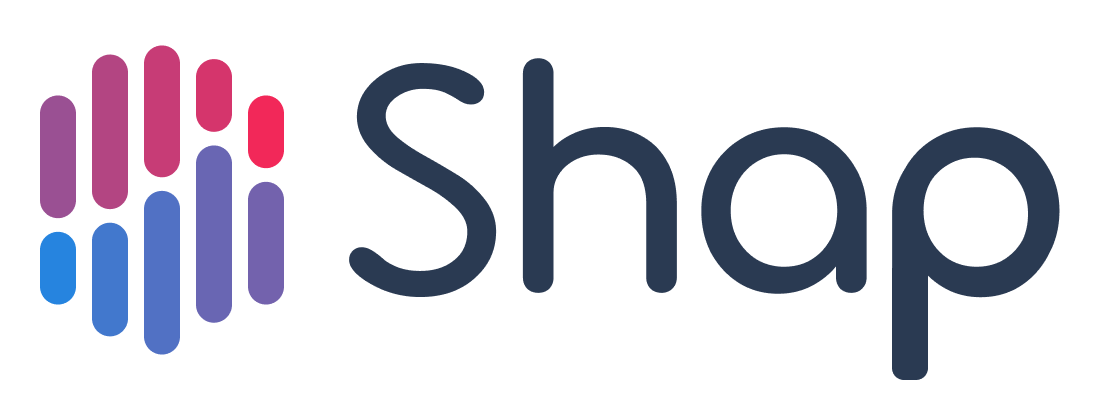

#### Source : https://github.com/slundberg/shap/issues/831

---

# Interprétation avec les valeurs de Shap :

---

In [44]:
pip install shap

     -------------------------------------- 435.6/435.6 kB 5.5 MB/s eta 0:00:00
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [45]:
import shap

In [48]:
features = X.columns

In [46]:
# Récupérer le meilleur modèle entraîné :
best_model = grid_search.best_estimator_

# Créer l'objet pour le calcul des valeurs de Shap :
explainer = shap.TreeExplainer(best_model)
#explainer = shap.TreeExplainer(regressor)

# Calculer les valeurs de Shap :
shap_values = explainer.shap_values(X_train)

---

## SHAP Feature importance

---

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


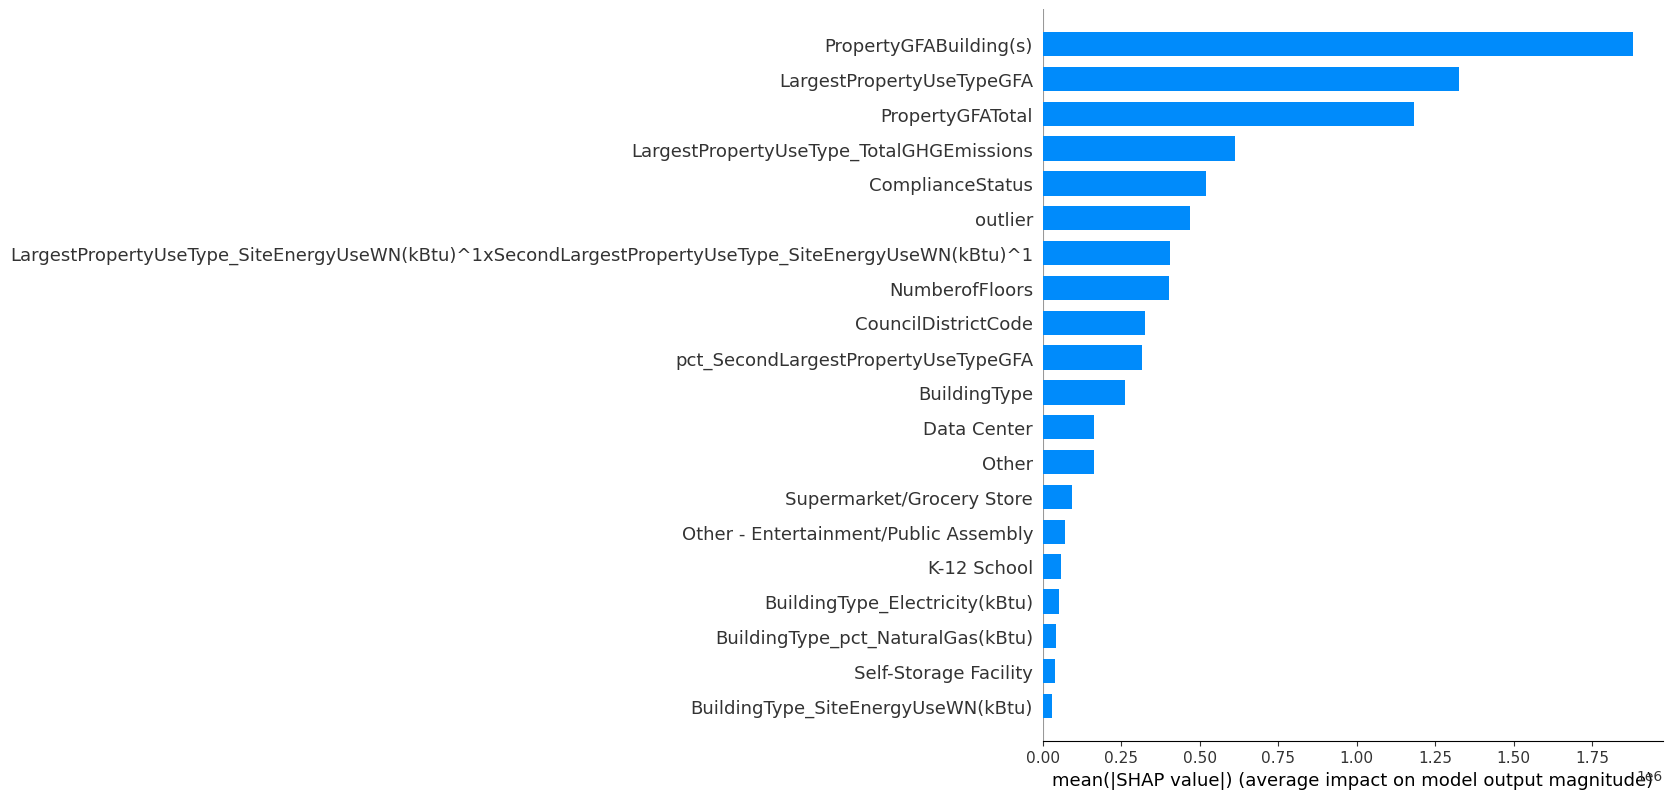

In [49]:
shap.summary_plot(shap_values, X_train, feature_names=features, plot_type="bar")

---

## SHAP Summary Plot

---

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


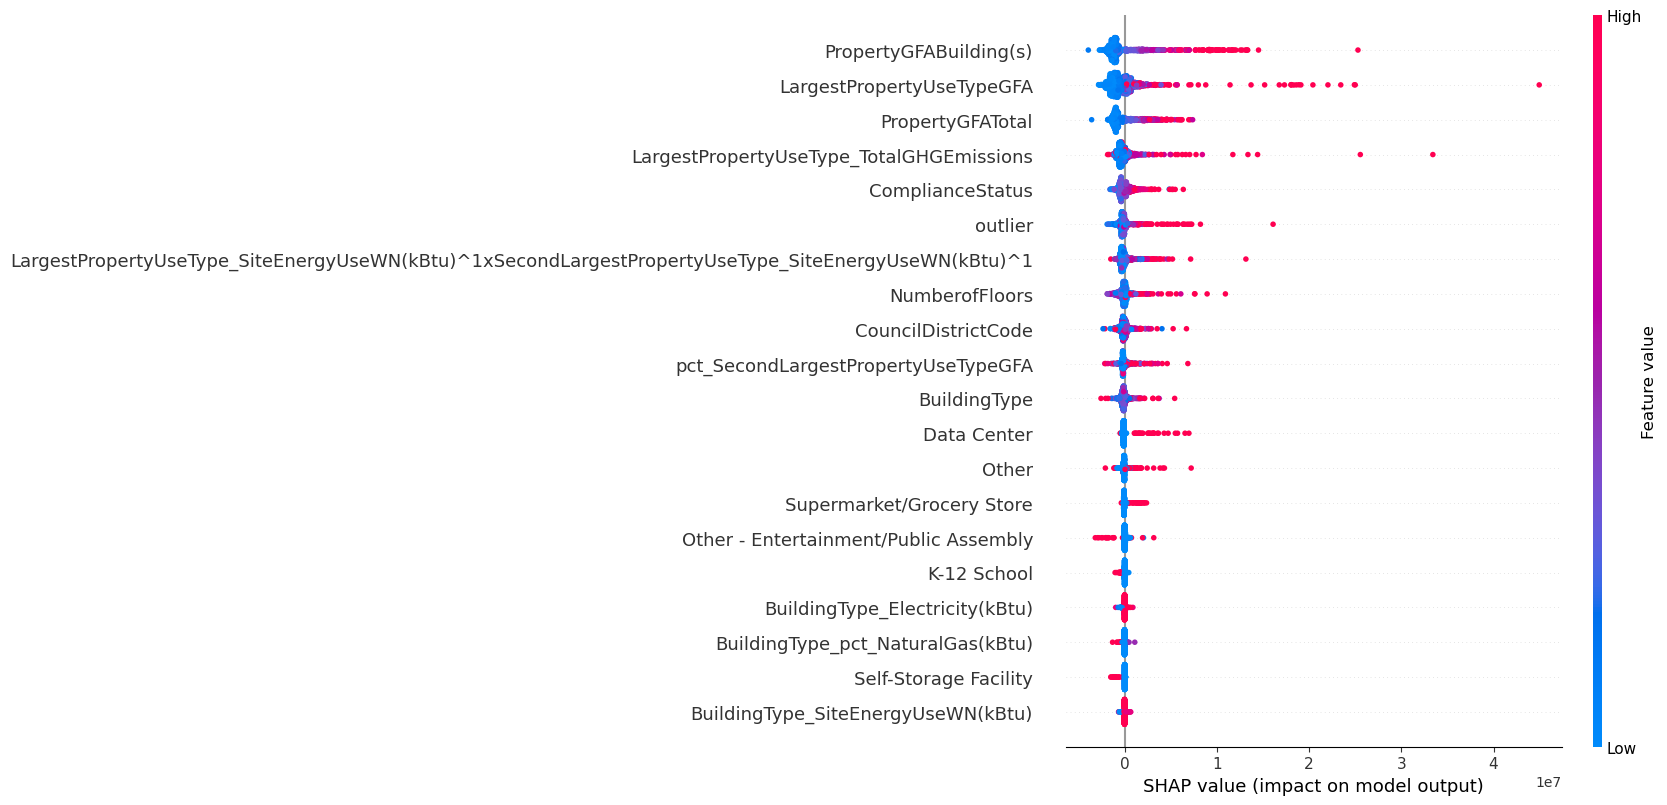

In [50]:
shap.summary_plot(shap_values, X_train, feature_names=features)

## SHAP Dependence Plot

---

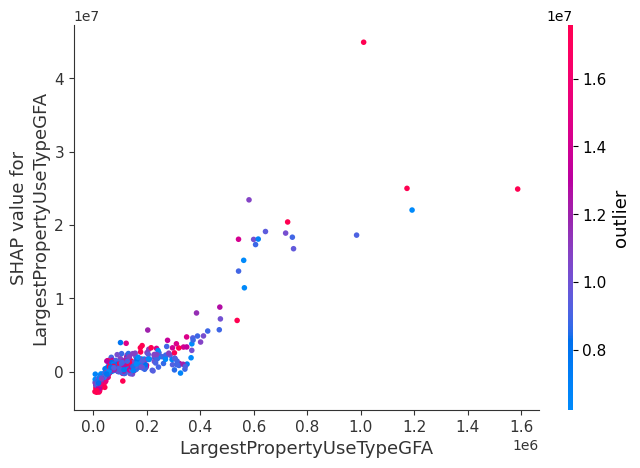

In [51]:
shap.dependence_plot(5, shap_values, X_train, feature_names=features)

---

#### 📌 Initialisation de js (javascript) :

In [77]:
shap.initjs()

---

## SHAP Force plot

---

In [101]:
i = 1
#shap.force_plot(explainer.expected_value, shap_values[i], X_test[i], feature_names = features)
shap.force_plot(explainer.expected_value, shap_values[i], X_test[:i], feature_names = features)

In [79]:
# visualize the first 5 predictions explanations with a dark red dark blue color map.
shap.force_plot(explainer.expected_value, shap_values[0:5], X_test[0:5], plot_cmap="DrDb", feature_names=features)

---

## SHAP Decision plot

---

In [106]:
shap.decision_plot(explainer.expected_value[1], shap_values[:1], feature_names = list(features))

IndexError: invalid index to scalar variable.

---

### Autre modèle qui pourra être tester à l'avenir :

In [ ]:
### Source : https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna